## CNN Audio Classification based on Filter Banks for the Google Command Dataset.
## MobileNet

In [1]:
import os
#Find out platform where we are running.
PLATFORM = "GENERIC"
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  PLATFORM = "COLAB"
else:
    if(os.name=='nt'):
        PLATFORM = 'WINDOWS'
    elif(os.name=='posix'):
        PLATFORM = 'LINUX'
    print("Running on "+PLATFORM)

Running on WINDOWS


In [2]:
if PLATFORM=='COLAB':
    !pip install SoundFile
    !pip install librosa
    !pip install SpeechRecognition
    !pip install keras

Google Drive import

In [3]:
if PLATFORM=='COLAB':
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
if PLATFORM=='COLAB':
    !unzip "/content/gdrive/My Drive/data/speech_commands_v0.02_IMG.zip" -d "/content"

In [5]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as display
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random
from keras import backend as K

Using TensorFlow backend.


In [6]:
#Add drive to path to be able to mount from there.
if PLATFORM=='COLAB':
    sys.path.append('/content/gdrive/My Drive/Colab Notebooks') #here is src located
    PROJECT_HOME = os.path.dirname(os.getcwd())
else:
  #PROJECT_HOME = os.getcwd()+"/"
  # NOTE that in this Jupyter notebook, the parent folder is the project home, not this!
  PROJECT_HOME = 'D:/Student Project MAML/'
  PROJECT_HOME = os.path.dirname(os.getcwd())+"/"  

sys.path.append("..") # Adds higher directory to python modules path. This is important to load the libraries  in PROJECT_HOME/src/
import src.d01_load_data as ld #Library to load data and handle data.
import src.preprocess_dataset as prepDS #Add the library where the code to split the dataset is located.


checkpointPath = PROJECT_HOME+"Speech Recognition/checkpoints/"
#commands = ["yes","one","left","bird","cat","dog"]
commands = ["yes","no"]
commands = ["yes","one","left","bird"]
commands = "ALL"

#SAMPLES_PER_CLASS = 100
SAMPLES_PER_CLASS = "ALL"


#commands = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [7]:
#GPU Available?
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [8]:
# Execute:
# python create_img_dataset.py

In [9]:
#SR_DATA = "Speech Recognition/speech_commands_mini_IMG/" #Command dataset folder.
SR_DATA = "Speech Recognition/speech_commands_minmed_IMG/" #Command dataset folder.
SR_DATA = "Speech Recognition/speech_commands_v0.01_IMG/" #Command dataset folder.
SR_DATA = "Speech Recognition/speech_commands_v0.02_IMG/" #Command dataset folder.
#SR_DATA = "Speech Recognition/speech_commands_v0.01_reverse_IMG/" #Command dataset folder.
#SR_DATA = "Speech Recognition/speech_commands_medium_IMG/" #Command dataset folder.
#SR_DATA="Speech Recognition/commands_multilanguage/spanish_WAV_IMG/" 

if PLATFORM is "COLAB":
    SR_DATA = "content/speech_commands_v0.02_IMG/" #Command dataset folder.

data_dir = PROJECT_HOME + SR_DATA

BATCH_SIZE = 8
IMG_HEIGHT = 40
IMG_WIDTH = 100

train_per = 0.8
val_per = 0.1
test_per = 0.1

lr = 0.0005

### Data Pipeline

In [10]:
AUTOTUNE=tf.data.experimental.AUTOTUNE

### Process Google command dataset

In [11]:
#Normal dataset for training.
print(PROJECT_HOME)
data_path,DATASET_SIZE,CLASS_NAMES = prepDS.getInfoDataset(PROJECT_HOME+SR_DATA)
print(data_path)
print("DATASET_SIZE before filtering: ",DATASET_SIZE)
labeled_ds,DATASET_SIZE,CLASS_NAMES = prepDS.getLabeledDS(data_path,DATASET_SIZE,CLASS_NAMES,AUTOTUNE,IMG_WIDTH,IMG_HEIGHT,commands, SAMPLES_PER_CLASS,PLATFORM)
train_ds, test_ds, val_ds = prepDS.prepare_for_training(labeled_ds, train_per, val_per, test_per,DATASET_SIZE,BATCH_SIZE,AUTOTUNE, cache=False, shuffle_buffer_size=1000,epochs=1)
print("DATASET_SIZE after filtering: ",DATASET_SIZE)
print(CLASS_NAMES)

class_names = list(CLASS_NAMES)
class_names

C:\Users\ece_a\Desktop\Github\studentproject/
C:\Users\ece_a\Desktop\Github\studentproject\Speech Recognition\speech_commands_v0.02_IMG
DATASET_SIZE before filtering:  106231
There are  106231  samples in the filtered dataset.
DATASET_SIZE after filtering:  106231
['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


['_background_noise_',
 'backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

### Paper split

In [12]:
digits=['zero','one','two','three','four','five','six','seven','eight','nine']
commands_10=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

allCommandsL = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow',
 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no',
 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
 'two', 'up', 'visual', 'wow', 'yes', 'zero','_background_noise_']

unknown = ['bed','dog','happy','marvin','wow']

silence = ['_background_noise_']

known_d = list(set(allCommandsL) - set(digits) - set(unknown) - set(silence))
known_10 = list(set(allCommandsL) - set(commands_10) - set(unknown) - set(silence))

print(known_d)
print(known_10)

['cat', 'up', 'visual', 'backward', 'learn', 'go', 'follow', 'sheila', 'stop', 'no', 'left', 'forward', 'house', 'yes', 'down', 'off', 'bird', 'right', 'tree', 'on']
['cat', 'visual', 'backward', 'learn', 'follow', 'sheila', 'one', 'six', 'two', 'forward', 'zero', 'four', 'house', 'three', 'nine', 'five', 'seven', 'eight', 'bird', 'tree']


In [13]:
#Known_d dataset
data_path,DATASET_SIZE,CLASS_NAMES = prepDS.getInfoDataset(PROJECT_HOME+SR_DATA)
print("DATASET_SIZE before filtering: ",DATASET_SIZE)
labeled_ds_kd,DATASET_SIZE_kd,CLASS_NAMES_kd = prepDS.getLabeledDS(data_path,DATASET_SIZE,CLASS_NAMES,AUTOTUNE,IMG_WIDTH,IMG_HEIGHT,known_d, SAMPLES_PER_CLASS,PLATFORM)
print(DATASET_SIZE_kd)
print(CLASS_NAMES_kd)


DATASET_SIZE before filtering:  106231
Update DATASIZE variables
There are  56502  samples in the filtered dataset.
56502
['cat' 'up' 'visual' 'backward' 'learn' 'go' 'follow' 'sheila' 'stop' 'no'
 'left' 'forward' 'house' 'yes' 'down' 'off' 'bird' 'right' 'tree' 'on']


In [14]:
#Known_10 dataset
data_path,DATASET_SIZE,CLASS_NAMES = prepDS.getInfoDataset(PROJECT_HOME+SR_DATA)
print("DATASET_SIZE before filtering: ",DATASET_SIZE)
labeled_ds_k10,DATASET_SIZE_k10,CLASS_NAMES_k10 = prepDS.getLabeledDS(data_path,DATASET_SIZE,CLASS_NAMES,AUTOTUNE,IMG_WIDTH,IMG_HEIGHT,known_10, SAMPLES_PER_CLASS,PLATFORM)
print(DATASET_SIZE_k10)
print(CLASS_NAMES_k10)

DATASET_SIZE before filtering:  106231
Update DATASIZE variables
There are  56864  samples in the filtered dataset.
56864
['cat' 'visual' 'backward' 'learn' 'follow' 'sheila' 'one' 'six' 'two'
 'forward' 'zero' 'four' 'house' 'three' 'nine' 'five' 'seven' 'eight'
 'bird' 'tree']


In [15]:
#unknown dataset
data_path,DATASET_SIZE,CLASS_NAMES = prepDS.getInfoDataset(PROJECT_HOME+SR_DATA)
print("DATASET_SIZE before filtering: ",DATASET_SIZE)
labeled_ds_u,DATASET_SIZE_u,CLASS_NAMES_u = prepDS.getLabeledDS(data_path,DATASET_SIZE,CLASS_NAMES,AUTOTUNE,IMG_WIDTH,IMG_HEIGHT,unknown, SAMPLES_PER_CLASS,PLATFORM)
print(DATASET_SIZE_u)
print(CLASS_NAMES_u)

DATASET_SIZE before filtering:  106231
Update DATASIZE variables
There are  10419  samples in the filtered dataset.
10419
['bed' 'dog' 'happy' 'marvin' 'wow']


In [16]:
#digits dataset
data_path,DATASET_SIZE,CLASS_NAMES = prepDS.getInfoDataset(PROJECT_HOME+SR_DATA)
print("DATASET_SIZE before filtering: ",DATASET_SIZE)
labeled_ds_d,DATASET_SIZE_d,CLASS_NAMES_d = prepDS.getLabeledDS(data_path,DATASET_SIZE,CLASS_NAMES,AUTOTUNE,IMG_WIDTH,IMG_HEIGHT,digits, SAMPLES_PER_CLASS,PLATFORM)
print(DATASET_SIZE_d)
print(CLASS_NAMES_d)

DATASET_SIZE before filtering:  106231
Update DATASIZE variables
There are  38908  samples in the filtered dataset.
38908
['zero' 'one' 'two' 'three' 'four' 'five' 'six' 'seven' 'eight' 'nine']


In [17]:
#commands_10 dataset
data_path,DATASET_SIZE,CLASS_NAMES = prepDS.getInfoDataset(PROJECT_HOME+SR_DATA)
print("DATASET_SIZE before filtering: ",DATASET_SIZE)
labeled_ds_c10,DATASET_SIZE_c10,CLASS_NAMES_c10 = prepDS.getLabeledDS(data_path,DATASET_SIZE,CLASS_NAMES,AUTOTUNE,IMG_WIDTH,IMG_HEIGHT,commands_10, SAMPLES_PER_CLASS,PLATFORM)
print(DATASET_SIZE_c10)
print(CLASS_NAMES_c10)

DATASET_SIZE before filtering:  106231
Update DATASIZE variables
There are  38546  samples in the filtered dataset.
38546
['yes' 'no' 'up' 'down' 'left' 'right' 'on' 'off' 'stop' 'go']


In [18]:
#silence dataset
data_path,DATASET_SIZE,CLASS_NAMES = prepDS.getInfoDataset(PROJECT_HOME+SR_DATA)
print("DATASET_SIZE before filtering: ",DATASET_SIZE)
labeled_ds_silence,DATASET_SIZE_silence,CLASS_NAMES_silence = prepDS.getLabeledDS(data_path,DATASET_SIZE,CLASS_NAMES,AUTOTUNE,IMG_WIDTH,IMG_HEIGHT,silence, SAMPLES_PER_CLASS,PLATFORM)
print(DATASET_SIZE_silence)
print(CLASS_NAMES_silence)

DATASET_SIZE before filtering:  106231
Update DATASIZE variables
There are  402  samples in the filtered dataset.
402
['_background_noise_']


### Process Spanish Dataset

In [ ]:
#Dataset for transfer learning.
SPANISH_DATA="Speech Recognition/commands_multilanguage/spanish_WAV_IMG/"

data_path_SPA,DATASET_SIZE_SPA,CLASS_NAMES_SPA = prepDS.getInfoDataset(PROJECT_HOME+SPANISH_DATA)
print(data_path_SPA)
print("DATASET_SIZE before filtering: ",DATASET_SIZE_SPA)
labeled_ds_SPA,DATASET_SPA_SIZE,CLASS_NAMES_SPA = prepDS.getLabeledDS(data_path_SPA,DATASET_SIZE_SPA,CLASS_NAMES_SPA,AUTOTUNE,IMG_WIDTH,IMG_HEIGHT,commands="ALL", SAMPLES_PER_CLASS="ALL",PLATFORM=PLATFORM)
train_ds_SPA, test_ds_SPA, val_ds_SPA = prepDS.prepare_for_training(labeled_ds_SPA, train_per, val_per, test_per,DATASET_SIZE_SPA,BATCH_SIZE,AUTOTUNE, cache=False, shuffle_buffer_size=1000,epochs=1)
print("DATASET_SIZE after filtering: ",DATASET_SIZE_SPA)
print(CLASS_NAMES_SPA)

C:\Users\Naveen kumar Ramu\studentproject-master\Speech Recognition\commands_multilanguage\spanish_WAV_IMG
DATASET_SIZE before filtering:  570
There are  570  samples in the filtered dataset.
DATASET_SIZE after filtering:  570
['agua' 'amigo' 'azul' 'cafe' 'carro' 'cerveza' 'gato' 'gracias' 'hola'
 'mujer' 'queso']


### Process German Dataset

In [ ]:
#Dataset for transfer learning.
GERMAN_DATA="Speech Recognition/commands_multilanguage/german_WAV_IMG/"

data_path_DE,DATASET_SIZE_DE,CLASS_NAMES_DE = prepDS.getInfoDataset(PROJECT_HOME+GERMAN_DATA)
print(data_path_DE)
print("DATASET_SIZE before filtering: ",DATASET_SIZE_DE)
labeled_ds_DE,DATASET_SIZE_DE,CLASS_NAMES_DE = prepDS.getLabeledDS(data_path_DE,DATASET_SIZE_DE,CLASS_NAMES_DE,AUTOTUNE,IMG_WIDTH,IMG_HEIGHT,commands="ALL", SAMPLES_PER_CLASS="ALL",PLATFORM=PLATFORM)
train_ds_DE, test_ds_DE, val_ds_DE = prepDS.prepare_for_training(labeled_ds, train_per, val_per, test_per,DATASET_SIZE_DE,BATCH_SIZE,AUTOTUNE, cache=False, shuffle_buffer_size=1000,epochs=1)
print("DATASET_SIZE after filtering: ",DATASET_SIZE_DE)
print(CLASS_NAMES_DE)

C:\Users\Naveen kumar Ramu\studentproject-master\Speech Recognition\commands_multilanguage\german_WAV_IMG
DATASET_SIZE before filtering:  273
There are  273  samples in the filtered dataset.
DATASET_SIZE after filtering:  273
['auto' 'bier' 'brot' 'danke' 'hallo' 'haus' 'hund' 'maedchen' 'richtig'
 'stadt']


In [ ]:
#----Image Pipeline ENDS----

## MobileNet Architechture

### MobileNet V1

In [19]:
# Source: https://colab.research.google.com/drive/1uUYdZk7EbOESRP7JFwHfsR7b9gUjxU75#scrollTo=O8YDQ9cJoQus&forceEdit=true&sandboxMode=true
# Note: You may use tf.keras.layers.DepthwiseConv2D but you won't be able to add BatchNorm and LeakyReLU layers.
# Hence, we are first performing depthwise convolutions and then a Conv2D with kernel size of 1.
def SeparableConv( x , num_filters , strides , alpha=1.0 ):
    x = tf.keras.layers.DepthwiseConv2D( kernel_size=3 , padding='same' )( x )
    x = tf.keras.layers.BatchNormalization(momentum=0.9997)( x )
    x = tf.keras.layers.Activation( 'relu' )( x )
    x = tf.keras.layers.Conv2D( int(np.floor( num_filters * alpha )) , kernel_size=( 1 , 1 ) , strides=strides , use_bias=False , padding='same' )( x )
    x = tf.keras.layers.BatchNormalization(momentum=0.9997)(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def Conv( x , num_filters , kernel_size , strides=1 , alpha=1.0 ):
    x = tf.keras.layers.Conv2D( int(np.floor( num_filters * alpha )) , kernel_size=kernel_size , strides=strides , use_bias=False , padding='same' )( x )
    x = tf.keras.layers.BatchNormalization( momentum=0.9997 )(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def get_mobileNet(final_labels):
    # The number of classes are three.
    num_classes = final_labels
    #img_height = 40
    #img_width = 100
    FILTERS_1 = 32 # Originally 32
    FILTERS_2 = FILTERS_1*2 # 64
    FILTERS_3 = FILTERS_2*2 # 128
    FILTERS_4 = FILTERS_3*2 # 256
    FILTERS_5 = FILTERS_4*2 # 512
    FILTERS_6 = FILTERS_5*2 # 1024

    # The shape of the input image.
    #inputs = tf.keras.layers.Input( shape=( 300 , 300 , 3 ) )
    inputs = tf.keras.layers.Input( shape=( 100 , 40 , 1 ) )
    #inputs = tf.keras.layers.Input( shape=( img_height , img_width , 3 ) )

    x = Conv( inputs , num_filters=FILTERS_1 , kernel_size=1 , strides=2 )
    x = SeparableConv( x , num_filters=FILTERS_1 , strides=1 )
    """
    x = Conv( x , num_filters=FILTERS_2 , kernel_size=1 )
    x = SeparableConv( x , num_filters=FILTERS_2 , strides=2  )

    x = Conv( x , num_filters=FILTERS_3 , kernel_size=1 )
    x = SeparableConv( x , num_filters=FILTERS_3 , strides=1  )
    x = Conv( x , num_filters=FILTERS_3 , kernel_size=1 )
    x = SeparableConv( x , num_filters=FILTERS_3 , strides=2  )
    x = Conv( x , num_filters=FILTERS_4 , kernel_size=1 )
    x = SeparableConv( x , num_filters=FILTERS_4 , strides=1  )
    x = Conv( x , num_filters=FILTERS_4 , kernel_size=1 )
    x = SeparableConv( x , num_filters=FILTERS_4 , strides=2  )
    x = Conv( x , num_filters=FILTERS_5 , kernel_size=1 )
    """
    # You may uncomment the code below if you're machine could tolerate such heavy computation!
    #for i in range( 5 ):
        #x = SeparableConv(x, num_filters=512 , strides=1 )
        #x = Conv(x, num_filters=512 , kernel_size=1 )
    """
    x = SeparableConv(x, num_filters=FILTERS_5 , strides=2 )
    x = Conv(x, num_filters=FILTERS_6 , kernel_size=1 )
    """
    #x = tf.keras.layers.AveragePooling2D( pool_size=( 7 , 7 ) )( x )
    x = tf.keras.layers.AveragePooling2D( pool_size=( 3 , 3 ) )( x )
    x = tf.keras.layers.Flatten()( x )
    x = tf.keras.layers.Dense( num_classes )( x )
    outputs = tf.keras.layers.Activation( 'softmax' )( x )

    model = tf.keras.models.Model( inputs , outputs )
    
    return model

In [ ]:
model = get_mobileNet(len(class_names))
# As we doing classification, we'll use categorical crossentropy and the RMSProp optimizer.
#model.compile( loss='categorical_crossentropy' , optimizer='rmsprop' , metrics=[ 'acc' ] )
model.compile( loss='categorical_crossentropy' , optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005) , metrics=[ 'acc' ] )

### MobileNetV2

In [ ]:
#https://github.com/JonathanCMitchell/mobilenet_v2_keras
def relu6(x):
    return K.relu(x, max_value=6)

def first_inverted_res_block(x, expansion, stride, alpha, filters, block_id):
    #DEPTHWISE STEP
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', name='%d_conv_dw'%block_id)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999, name='%d_conv_dw_bn'%block_id)(x)
    x = tf.keras.layers.Activation(relu6, name='%d_conv_dw_relu6' % block_id)(x)
    #PROJECT STEP
    x = tf.keras.layers.Conv2D(int(np.floor(filters * alpha)), kernel_size=(1,1), use_bias=False , padding='same', name='%d_conv_project'%block_id)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999, name='%d_conv_project_bn'%block_id)(x)
    return x

def inverted_res_block(x, expansion, stride, alpha, filters, block_id):
    in_channels = K.int_shape(x)[-1]
    pointwise_filters = int(filters * alpha)
    
    #EXPAND STEP
    x = tf.keras.layers.Conv2D(expansion * in_channels, kernel_size=1, use_bias=False, padding='same', name='%d_conv_expand' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999, name='%d_conv_expand_bn'%block_id)(x)
    x = tf.keras.layers.Activation(relu6, name='%d_conv_expand_relu' % block_id)(x)
    
    #DEPTHWISE STEP
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False, name='%d_conv_dw' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999, name='%d_conv_dw_bn' % block_id)(x)
    x = tf.keras.layers.Activation(relu6, name='%d_conv_dw_relu6' % block_id)(x)
    
    #PROJECT STEP
    x = tf.keras.layers.Conv2D(pointwise_filters, kernel_size=(1,1), use_bias=False, padding='same', name='%d_conv_project' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999, name='%d_conv_project_bn' % block_id)(x)
    return x


def get_mobileNetV2(final_labels, expansion):
    
    num_classes = final_labels
    alpha = 1.0
    expansion = expansion # expansion of the channels. it's 6 for every layer except in first layer in the paper.

    # The shape of the input image.
    inputs = tf.keras.layers.Input(shape=(100, 40, 1))
    row = K.int_shape(inputs)[1]

    x = tf.keras.layers.Conv2D(int(np.floor(32 * alpha)), kernel_size=1, 
                               strides=2, use_bias=False, padding='same', name="Conv1")(inputs)

    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999, name="Conv1_bn")(x)
    x = tf.keras.layers.Activation(relu6, name="Conv1_relu6")(x)

    x = first_inverted_res_block(x, expansion=1, filters=16, alpha=alpha, stride=1, block_id=0)

    x = inverted_res_block(x, filters=24, alpha=alpha, stride=2, expansion=expansion, block_id=1)

    x = inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=expansion, block_id=2)
    x = inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=expansion, block_id=3)
    x = inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=expansion, block_id=4)
    x = inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=expansion, block_id=5)
    x = inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=expansion, block_id=6)
    x = inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=expansion, block_id=7)
    x = inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=expansion, block_id=8)
    x = inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=expansion, block_id=9)
    x = inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=expansion, block_id=10)
    x = inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=expansion, block_id=11)
    x = inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=expansion, block_id=12)
    x = inverted_res_block(x, filters=160, alpha=alpha, stride=2, expansion=expansion, block_id=13)
    x = inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=expansion, block_id=14)
    x = inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=expansion, block_id=15)
    x = inverted_res_block(x, filters=320, alpha=alpha, stride=1, expansion=expansion, block_id=16)

    x = tf.keras.layers.Conv2D(1280, kernel_size=1, use_bias=False, name="Conv_1")(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999, name="Conv_1_bn")(x)
    x = tf.keras.layers.Activation(relu6, name="out_relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes, activation="softmax", use_bias=True, name="logits")(x)

    model = tf.keras.models.Model(inputs, x, name='mobilenetv2_large')
    return model

model = get_mobileNetV2(len(class_names), expansion = 6)
#model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.055, momentum=0.9, decay=0.9) , metrics=[ 'acc' ] )
model.compile( loss='categorical_crossentropy' , optimizer=tf.keras.optimizers.Adam(learning_rate = lr) , metrics=[ 'acc' ] )#model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001) , metrics=[ 'acc' ] )


In [ ]:
model.summary()

Model: "mobilenetv2_large"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 40, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 50, 20, 32)        32        
_________________________________________________________________
Conv1_bn (BatchNormalization (None, 50, 20, 32)        128       
_________________________________________________________________
Conv1_relu6 (Activation)     (None, 50, 20, 32)        0         
_________________________________________________________________
0_conv_dw (DepthwiseConv2D)  (None, 50, 20, 32)        320       
_________________________________________________________________
0_conv_dw_bn (BatchNormaliza (None, 50, 20, 32)        128       
_________________________________________________________________
0_conv_dw_relu6 (Activation) (None, 50, 20, 32)  

## TRAINING WITH MODEL.FIT()

In [ ]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard

In [ ]:
#%tensorboard --logdir logs

In [ ]:
epochs=50

In [ ]:
checkpoint_path = "checkpoints/mobilenetv2_modelfit/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
"""
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
"""
# Create a callback that saves the model's weights

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


#model.fit( train_ds , val_ds , epochs=5 , batch_size=25 )
#model.fit( train_X , train_Y , epochs=50 ,batch_size= 32, validation_data=(test_X, test_Y) ,callbacks=[cp_callback])
#model.fit( train_X , train_Y , epochs=50 ,batch_size= 32, validation_data=(test_X, test_Y) ,callbacks=[tensorboard_callback])
history = model.fit(
  train_ds,
  #batch_size= BATCH_SIZE,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[cp_callback]
)

In [ ]:
# Save the entire model
#!mkdir -p saved_model
if PLATFORM == 'COLAB':
    model.save('/content/gdrive/My Drive/saved_models/mobilenetv2')    

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.head()

In [ ]:
if PLATFORM == 'COLAB':
    path_to_save_outputs = '/content/gdrive/My Drive/saved_models/mobilenetv2_pandas/loss_history.csv'
else:
    path_to_save_outputs = "mobilenetv2_pandas/loss_history.csv"
filename = "training_with_" + str(model.name) + "_lr:" + str(lr) + "_BS:" + str(BATCH_SIZE) + "_epochs:" + str(epochs) + "_classes" + str(len(class_names))
    
losses.to_csv(path_to_save_outputs, index = False, header=True)

In [ ]:
losses[['loss','val_loss']].plot()
plt.title('Loss for {} Model \n Speech Recognition (SR)'.format(model.name))
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

losses[['acc','val_acc']].plot()
plt.title('Accuracy for {} Model \n Speech Recognition (SR)'.format(model.name))
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluate the model

In [ ]:
results = model.evaluate(test_ds)

print("test loss, test acc:", results)

In [ ]:
labels_test_truth = []
labels_test_pred = []
for x_test,y_test in test_ds:
    predictions = model.predict_on_batch(x_test)
    #print(predictions)
    predictions = tf.argmax(predictions, axis=-1)
    labels_test_pred += predictions.numpy().tolist() #Concatenate this batch predictions into a flat list.
    y_truth = tf.where(y_test)[:,1] #Take only the predictions
    labels_test_truth += y_truth.numpy().tolist() #Concatenate this batch ground truth.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def printConfusionMatrix(conf_mat,categories, acc,header="MobileNet Google Command"):
    """Displays a colored plot of the confusion matrix"""
    cm_df = pd.DataFrame(conf_mat,
                        index = categories, 
                        columns = categories)
    plt.figure(figsize=(15,10))
    sns.heatmap(cm_df, annot=False)
    plt.title(header+"\nAccuracy: "+str(round(acc,2)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()        

accuracy_test = round(accuracy_score(labels_test_truth, labels_test_pred)*100,2)
conf_mat = confusion_matrix(labels_test_truth, labels_test_pred)
print("Accuracy test: ",accuracy_test)
#print(conf_mat)
printConfusionMatrix(conf_mat,CLASS_NAMES.tolist(),accuracy_test)

## CUSTOM TRAINING

In [ ]:
#https://github.com/JonathanCMitchell/mobilenet_v2_keras
def relu6(x):
    return K.relu(x, max_value=6)

def first_inverted_res_block(x, expansion, stride, alpha, filters, block_id):
    #DEPTHWISE STEP
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', name='%d_conv_dw'%block_id)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999, name='%d_conv_dw_bn'%block_id)(x)
    x = tf.keras.layers.Activation(relu6, name='%d_conv_dw_relu6' % block_id)(x)
    #PROJECT STEP
    x = tf.keras.layers.Conv2D(int(np.floor(filters * alpha)), kernel_size=(1,1), use_bias=False , padding='same', name='%d_conv_project'%block_id)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999, name='%d_conv_project_bn'%block_id)(x)
    return x

def inverted_res_block(x, expansion, stride, alpha, filters, block_id):
    in_channels = K.int_shape(x)[-1]
    pointwise_filters = int(filters * alpha)
    
    #EXPAND STEP
    x = tf.keras.layers.Conv2D(expansion * in_channels, kernel_size=1, use_bias=False, padding='same', name='%d_conv_expand' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999, name='%d_conv_expand_bn'%block_id)(x)
    x = tf.keras.layers.Activation(relu6, name='%d_conv_expand_relu' % block_id)(x)
    
    #DEPTHWISE STEP
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False, name='%d_conv_dw' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999, name='%d_conv_dw_bn' % block_id)(x)
    x = tf.keras.layers.Activation(relu6, name='%d_conv_dw_relu6' % block_id)(x)
    
    #PROJECT STEP
    x = tf.keras.layers.Conv2D(pointwise_filters, kernel_size=(1,1), use_bias=False, padding='same', name='%d_conv_project' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999, name='%d_conv_project_bn' % block_id)(x)
    return x


def get_mobileNetV2_small(final_labels, expansion):
    
    num_classes = final_labels
    alpha = 1.0
    expansion = expansion # expansion of the channels. it's 6 for every layer except in first layer in the paper.

    # The shape of the input image.
    inputs = tf.keras.layers.Input(shape=(100, 40, 1))
    row = K.int_shape(inputs)[1]

    x = tf.keras.layers.Conv2D(int(np.floor(32 * alpha)), kernel_size=1, 
                               strides=2, use_bias=False, padding='same', name="Conv1")(inputs)

    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999, name="Conv1_bn")(x)
    x = tf.keras.layers.Activation(relu6, name="Conv1_relu6")(x)

    x = first_inverted_res_block(x, expansion=1, filters=16, alpha=alpha, stride=1, block_id=0)

    x = inverted_res_block(x, filters=24, alpha=alpha, stride=2, expansion=expansion, block_id=1)

    '''x = inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=expansion, block_id=2)
    x = inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=expansion, block_id=3)
    x = inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=expansion, block_id=4)
    x = inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=expansion, block_id=5)
    x = inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=expansion, block_id=6)
    x = inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=expansion, block_id=7)
    x = inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=expansion, block_id=8)
    x = inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=expansion, block_id=9)
    x = inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=expansion, block_id=10)
    x = inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=expansion, block_id=11)
    x = inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=expansion, block_id=12)
    x = inverted_res_block(x, filters=160, alpha=alpha, stride=2, expansion=expansion, block_id=13)
    x = inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=expansion, block_id=14)
    x = inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=expansion, block_id=15)
    x = inverted_res_block(x, filters=320, alpha=alpha, stride=1, expansion=expansion, block_id=16)'''

    x = tf.keras.layers.Conv2D(24, kernel_size=1, use_bias=False, name="Conv_1")(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1e-3, momentum=0.999, name="Conv_1_bn")(x)
    x = tf.keras.layers.Activation(relu6, name="out_relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes, activation="softmax", use_bias=True, name="logits")(x)

    model = tf.keras.models.Model(inputs, x, name='mobilenetv2_small)
    return model

In [ ]:
manual_model = get_mobileNetV2_small(len(class_names), expansion = 1)
manual_model.summary()

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
manual_model.compile(optimizer,loss_object,metrics=[tf.keras.metrics.CategoricalAccuracy()])
acc_object = tf.keras.metrics.CategoricalAccuracy()    


checkpoint_path = "checkpoints/mobilenetv2_custom/"
manual_model.save_weights("ckpt", checkpoint_path)

In [ ]:
from tensorflow.keras.utils import Progbar
num_training_samples = image_count*train_per/BATCH_SIZE

for epoch in range(30):
    batch_loss = []
    batch_acc = []
    print('Epoch',epoch+1)
    pb_i = Progbar(num_training_samples)
    for images,labels in train_ds:
        
        with tf.GradientTape() as tape:
            preds = manual_model(images)
            loss = loss_object(labels, preds)
            acc  = acc_object(labels, preds)
    
        grads = tape.gradient(loss, manual_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, manual_model.trainable_weights))
        pb_i.add(1)
        
        
    print('Train Evaluation')
    manual_model.evaluate(train_ds)
    print('Val Evaluation')
    manual_model.evaluate(val_ds)

In [ ]:
losses = pd.DataFrame(manual_model.history.history)
losses.head()

In [ ]:
losses[['loss','val_loss']].plot()
plt.title('Loss for {} Model \n Speech Recognition (SR)'.format(manual_model.name))
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

losses[['acc','val_acc']].plot()
plt.title('Accuracy for {} Model \n Speech Recognition (SR)'.format(manual_model.name))
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
results = manual_model.evaluate(test_ds)

print("test loss, test acc:", results)

In [ ]:
labels_test_truth = []
labels_test_pred = []
for x_test,y_test in test_ds:
    predictions = manual_model.predict_on_batch(x_test)
    #print(predictions)
    predictions = tf.argmax(predictions, axis=-1)
    labels_test_pred += predictions.numpy().tolist() #Concatenate this batch predictions into a flat list.
    y_truth = tf.where(y_test)[:,1] #Take only the predictions
    labels_test_truth += y_truth.numpy().tolist() #Concatenate this batch ground truth.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def printConfusionMatrix(conf_mat,categories, acc,header="MobileNet Google Command"):
    """Displays a colored plot of the confusion matrix"""
    cm_df = pd.DataFrame(conf_mat,
                        index = categories, 
                        columns = categories)
    plt.figure(figsize=(15,10))
    sns.heatmap(cm_df, annot=False)
    plt.title(header+"\nAccuracy: "+str(round(acc,2)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()        

accuracy_test = round(accuracy_score(labels_test_truth, labels_test_pred)*100,2)
conf_mat = confusion_matrix(labels_test_truth, labels_test_pred)
print("Accuracy test: ",accuracy_test)
#print(conf_mat)
printConfusionMatrix(conf_mat,CLASS_NAMES.tolist(),accuracy_test)

# Reptile - MAML

In [20]:
img_height = 40
img_width = 100
batch_size = 1

# Prepare the dataset for MAML training

In [21]:
class CombineData:
    def __init__(self, labeled_ds):
        self.data = {}

        for image, label in labeled_ds:
            image = image.numpy()
            index = [i for i, x in enumerate(label.numpy()) if x][0]
            if index not in self.data:
                self.data[index] = []
            self.data[index].append(image)
            
    def return_data(self,num_of_classes=5,dataset_type='known'):
        
        train_data = []
        train_label = []
        
        if dataset_type == 'known':
            for idx in range(len(self.data.keys())):
                dt = self.data[idx]
                temp_labels = np.zeros(shape=(len(dt)))
                temp_labels[0: len(dt)] = idx
                train_data += dt
                train_label += list(temp_labels)

        elif dataset_type == 'silence':
            for idx in range(len(self.data.keys())):
                dt = self.data[idx]
                temp_labels = np.zeros(shape=(len(dt)))
                temp_labels[0: len(dt)] = num_of_classes
                train_data += dt
                train_label += list(temp_labels)
                
        else:
            for idx in range(len(self.data.keys())):
                dt = self.data[idx]
                temp_labels = np.zeros(shape=(len(dt)))
                temp_labels[0: len(dt)] = num_of_classes + 1
                train_data += dt
                train_label += list(temp_labels)

        train = tf.data.Dataset.from_tensor_slices(
            (np.array(train_data).astype(np.float32), np.array(train_label).astype(np.int32))
        )
        
        return train

    def data_split(self):

        train_data = []
        train_label = []
        test_data = []
        test_label = []

        for idx in range(len(self.data.keys())):
            dt = self.data[idx]
            temp_labels = np.zeros(shape=(len(dt)))
            temp_labels[0: len(dt)] = idx
            if idx < (len(self.data.keys()) - 5):
                train_data += dt
                train_label += list(temp_labels)
            else:
                test_data += dt
                test_label += list(temp_labels)

        train = tf.data.Dataset.from_tensor_slices(
            (np.array(train_data).astype(np.float32), np.array(train_label).astype(np.int32))
        )

        test = tf.data.Dataset.from_tensor_slices(
            (np.array(test_data).astype(np.float32), np.array(test_label).astype(np.int32))
        )

        return train,test

class MAMLDataSet:
    def __init__(self, ds, k_subset_label, img_height, img_width, train_type = 'general', u_ds=None, s_ds=None):

        self.img_height = img_height
        self.img_width = img_width
        self.data = {}
        self.u_data = {}
        self.s_data = {}
        self.subset_labels = {}

        subset_sample = []
        meta_index = 0
        self.train_type = train_type

        if train_type == 'general':
            for image, label in ds:
                image = image.numpy()
                label = str(label.numpy())
                if label not in self.data:
                    self.data[label] = []
                self.data[label].append(image)
                self.labels = list(self.data.keys())
        else:
            for image, label in ds:
                image = image.numpy()
                label = str(label.numpy())
                if label not in self.data:
                    self.data[label] = []
                self.data[label].append(image)
                self.labels = list(self.data.keys())
                
            for image, label in u_ds:
                image = image.numpy()
                label = str(label.numpy())
                if label not in self.u_data:
                    self.u_data[label] = []
                self.u_data[label].append(image)
                self.u_labels = list(self.u_data.keys())

            for image, label in s_ds:
                image = image.numpy()
                label = str(label.numpy())
                if label not in self.s_data:
                    self.s_data[label] = []
                self.s_data[label].append(image)
                self.s_labels = list(self.s_data.keys())  

#         unique_samples = list(set(self.labels))

#         while len(subset_sample) < len(unique_samples):
#             random_subset = [j for j in unique_samples if j not in subset_sample]
#             a = random.choices(random_subset, k=k_subset_label)
#             if meta_index not in self.subset_labels:
#                 self.subset_labels[meta_index] = []
#             self.subset_labels[meta_index] = a
#             subset_sample += a
#             meta_index += 1

    def get_mini_dataset_paper(self, batch_size, repetitions, shots, num_classes, split=False):
        
        num_classes = num_classes + 2
        
        temp_labels = np.zeros(shape=(num_classes * shots, num_classes ))
        temp_images = np.zeros(shape=(num_classes * shots, self.img_width, self.img_height, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes * shots, num_classes ))
            test_images = np.zeros(shape=(num_classes * shots, self.img_width, self.img_height, 1))
        # Get a random subset of labels from the entire label set.
#         meta_index = random.choices(list(self.subset_labels.keys()), k=1)[0]
#         label_subset = self.subset_labels[meta_index]

        
        label_subset = random.choices(self.labels, k=num_classes-1)
        
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots: (class_idx + 1) * shots] = tf.one_hot(class_idx, num_classes)
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx * shots: (class_idx + 1) * shots] = tf.one_hot(class_idx, num_classes)
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + shots
                )
                test_images[class_idx * shots: (class_idx + 1) * shots] = images_to_split[-shots:]
                temp_images[
                class_idx * shots: (class_idx + 1) * shots
                ] = images_to_split[:-shots]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                class_idx * shots: (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)
                
        temp_labels[(num_classes - 1) * shots: (num_classes) * shots] = tf.one_hot(num_classes-1, num_classes)
        if split:
            test_labels[(num_classes - 1) * shots: (num_classes) * shots] = tf.one_hot(num_classes-1, num_classes)
            images_to_split = random.choices(
            self.u_data[str(num_classes-1)], k=shots + shots)
            test_images[(num_classes - 1) * shots: (num_classes) * shots] = images_to_split[-shots:]   
            temp_images[
            (num_classes - 1) * shots: (num_classes) * shots
            ] = images_to_split[:-shots]
        else:
            temp_images[
            (num_classes - 1) * shots: (num_classes) * shots
            ] = random.choices(self.u_data[str(num_classes-1)], k=shots)


        temp_labels[(num_classes - 2) * shots: (num_classes-1) * shots] = tf.one_hot(num_classes-2, num_classes)
        if split:
            test_labels[(num_classes - 2) * shots: (num_classes-1) * shots] = tf.one_hot(num_classes-2, num_classes)
            images_to_split = random.choices(
            self.s_data[str(num_classes-2)], k=shots + shots)
            test_images[(num_classes - 2) * shots: (num_classes-1) * shots] = images_to_split[-shots:]   
            temp_images[
            (num_classes - 2) * shots: (num_classes-1) * shots
            ] = images_to_split[:-shots]
        else:
            temp_images[
            (num_classes - 2) * shots: (num_classes-1) * shots
            ] = random.choices(self.s_data[str(num_classes-2)], k=shots)
        
        
        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )

        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)

        if split:
            test_dataset = tf.data.Dataset.from_tensor_slices(
            (test_images.astype(np.float32), test_labels.astype(np.int32)))

            test_dataset = test_dataset.shuffle(5).batch(batch_size)
            return dataset, test_dataset
        return dataset

    def get_mini_dataset(self, batch_size, repetitions, shots, num_classes, split=False):

        temp_labels = np.zeros(shape=(num_classes * shots, num_classes))
        temp_images = np.zeros(shape=(num_classes * shots, self.img_width, self.img_height, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes * shots, num_classes))
            test_images = np.zeros(shape=(num_classes * shots, self.img_width, self.img_height, 1))
        # Get a random subset of labels from the entire label set.
#         meta_index = random.choices(list(self.subset_labels.keys()), k=1)[0]
#         label_subset = self.subset_labels[meta_index]

        
        label_subset = random.choices(self.labels, k=num_classes)
        
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            
            
            temp_labels[class_idx * shots: (class_idx + 1) * shots] = tf.one_hot(class_idx, num_classes)
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx * shots: (class_idx + 1) * shots] = tf.one_hot(class_idx, num_classes)
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + shots
                )
                test_images[class_idx * shots: (class_idx + 1) * shots] = images_to_split[-shots:]
                temp_images[
                class_idx * shots: (class_idx + 1) * shots
                ] = images_to_split[:-shots]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                class_idx * shots: (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)
                

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )

        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)

        if split:
            test_dataset = tf.data.Dataset.from_tensor_slices(
            (test_images.astype(np.float32), test_labels.astype(np.int32)))

            test_dataset = test_dataset.shuffle(5).batch(batch_size)
            return dataset, test_dataset
        return dataset
    
    
class Reptile:
    def __init__(self,inner_batch_size,eval_batch_size,meta_iters,eval_iters,inner_iters,train_shots,shots,classes,inner_learning_rate):
        
        self.meta_step_size = meta_step_size #0.09 #Beta

        self.inner_batch_size = inner_batch_size #5
        self.eval_batch_size = eval_batch_size #5

        self.meta_iters = meta_iters #2000
        self.eval_iters = eval_iters #5
        self.inner_iters = inner_iters #5

        self.train_shots = train_shots #20 
        self.shots = shots #5 
        self.classes = classes #5

        self.inner_learning_rate = inner_learning_rate #0.0001 #Alpha

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.inner_learning_rate)
        
        self.maml_model = get_mobileNet(classes+2)
        
        self.maml_model.compile( loss='categorical_crossentropy' ,
                           optimizer= self.optimizer,
                           metrics=['categorical_accuracy'])
        
        self.trained_weights = None
        
    
    def reptile_train(self,train_dataset,test_dataset):
        
        meta_test_set, meta_test = test_dataset.get_mini_dataset_paper(
            self.eval_batch_size, self.eval_iters, self.shots, self.classes, split=True
        )
        
        train = []
        
        afterTraining_train_loss = []
        afterTraining_test_loss = []
        afterTraining_train_acc = []
        afterTraining_test_acc = []
        
        afterMetaTrain_train_loss = []
        afterMetaTrain_test_loss = []
        afterMetaTrain_train_acc = []
        afterMetaTrain_test_acc = []
        
        afterMetaTest_train_loss = []
        afterMetaTest_test_loss = []
        afterMetaTest_train_acc = []
        afterMetaTest_test_acc = []
        
        print('start')
        for meta_iter in range(self.meta_iters):
            frac_done = meta_iter / meta_iters
            cur_meta_step_size = (1 - frac_done) * meta_step_size
            print('Epoch:',meta_iter)
            
            old_vars = self.maml_model.get_weights()
            mini_dataset,meta_val = train_dataset.get_mini_dataset_paper(
            self.inner_batch_size, self.inner_iters, self.train_shots, self.classes, split=True)

            print('Before Training')
            metrics = self.maml_model.evaluate(mini_dataset)
            metrics = self.maml_model.evaluate(meta_val)

            for images, labels in mini_dataset:
                with tf.GradientTape() as tape:
                    preds = self.maml_model(images)
                    loss = keras.losses.categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, self.maml_model.trainable_weights) 
                self.optimizer.apply_gradients(zip(grads, self.maml_model.trainable_weights))

            print('After Training')
            metrics = self.maml_model.evaluate(mini_dataset)
            afterTraining_train_loss.append(metrics[0])
            afterTraining_train_acc.append(metrics[1])
            
            metrics = self.maml_model.evaluate(meta_val)
            afterTraining_test_loss.append(metrics[0])
            afterTraining_test_acc.append(metrics[1])

            #maml_model.evaluate(mini_dataset)
            new_vars = self.maml_model.get_weights()
            # Perform SGD for the meta step.
            for var in range(len(new_vars)):
                new_vars[var] = old_vars[var] + (
                    (new_vars[var] - old_vars[var]) * cur_meta_step_size 
                )

            self.maml_model.set_weights(new_vars)

            print('After Meta Train Step')
            metrics = self.maml_model.evaluate(mini_dataset) 
            afterMetaTrain_train_loss.append(metrics[0])
            afterMetaTrain_train_acc.append(metrics[1])
            
            metrics = self.maml_model.evaluate(meta_val)
            afterMetaTrain_test_loss.append(metrics[0])
            afterMetaTrain_test_acc.append(metrics[1])

            old_vars = self.maml_model.get_weights()
            # After the meta-learning step, reload the newly-trained weights into the model.
            print('Before Meta Test Step')
            metrics = self.maml_model.evaluate(meta_test_set)
            metrics = self.maml_model.evaluate(meta_test)

            for images, labels in meta_test_set:
                with tf.GradientTape() as tape:
                    preds = self.maml_model(images)
                    loss1 = keras.losses.categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss1, self.maml_model.trainable_weights) 
                self.optimizer.apply_gradients(zip(grads, self.maml_model.trainable_weights))

            print('After Meta Test Step')
            metrics = self.maml_model.evaluate(meta_test_set)
            afterMetaTest_train_loss.append(metrics[0])
            afterMetaTest_train_acc.append(metrics[1])
            
            metrics = self.maml_model.evaluate(meta_test)
            afterMetaTest_test_loss.append(metrics[0])
            afterMetaTest_test_acc.append(metrics[1])

            self.maml_model.set_weights(old_vars)
            
        self.trained_weights = self.maml_model.get_weights()
        
        print('Model Training Completed')
        return afterTraining_train_loss, afterTraining_test_loss, afterTraining_train_acc, afterTraining_test_acc, afterMetaTrain_train_loss, afterMetaTrain_test_loss, afterMetaTrain_train_acc, afterMetaTrain_test_acc, afterMetaTest_train_loss, afterMetaTest_test_loss, afterMetaTest_train_acc, afterMetaTest_test_acc
    
    
    def reptile_test(self,train,test,epochs,transfer_weights=False):
        
        
        if transfer_weights:
            self.maml_model.set_weights(self.trained_weights)
        else:
            self.maml_model.set_weights(self.initial_weights)
        
        train_loss = []
        test_loss = []
        
        train_acc = []
        test_acc = []
    
        
        for epoch in range(epochs):
            for images, labels in train:
                with tf.GradientTape() as tape:
                    preds = self.maml_model(images)
                    loss1 = keras.losses.categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss1, self.maml_model.trainable_weights) 
                optimizer.apply_gradients(zip(grads, self.maml_model.trainable_weights))
                
                
            print('epoch:',epoch)
            metrics = self.maml_model.evaluate(train)
            train_loss.append(metrics[0])
            train_acc.append(metrics[1])

            metrics = self.maml_model.evaluate(test)
            test_loss.append(metrics[0])
            test_acc.append(metrics[1])
        
        return self.maml_model,train_loss,train_acc,test_loss,test_acc

In [22]:
meta_step_size = 0.09 #Beta

inner_batch_size = 5
eval_batch_size = 1

meta_iters = 2000
eval_iters = 5
inner_iters = 10

train_shots = 20
shots = 5 
classes = 10

inner_learning_rate = 0.0001 #Alpha
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

### Paper split

In [23]:
convert_to_maml_dataformat = CombineData(labeled_ds_u)
train_u = convert_to_maml_dataformat.return_data(classes,'unknown')

convert_to_maml_dataformat = CombineData(labeled_ds_silence)
train_s = convert_to_maml_dataformat.return_data(classes,'silence')

#use these two + unknown dataset for digits classification
convert_to_maml_dataformat = CombineData(labeled_ds_kd)
train_kd = convert_to_maml_dataformat.return_data()

convert_to_maml_dataformat = CombineData(labeled_ds_d)
test_d = convert_to_maml_dataformat.return_data()

#use these two + unknown dataset for commands classification
#convert_to_maml_dataformat = CombineData(labeled_ds_k10)
#train_k10 = convert_to_maml_dataformat.return_data()

#convert_to_maml_dataformat = CombineData(labeled_ds_c10)
#test_c10 = convert_to_maml_dataformat.return_data()

### Normal split

In [ ]:
convert_to_maml_dataformat = CombineData(labeled_ds)
train,test = convert_to_maml_dataformat.data_split()

convert_to_maml_dataformat_SPA = CombineData(labeled_ds_SPA)
train_SPA,test_SPA = convert_to_maml_dataformat_SPA.data_split()

KeyboardInterrupt: ignored

In [ ]:
convert_to_maml_dataformat_SPA = CombineData(labeled_ds_SPA)
train_SPA,test_SPA = convert_to_maml_dataformat_SPA.data_split()

MAML TRAINING


In [24]:
train_dataset = MAMLDataSet(train_kd,classes,img_height, img_width, 'paper', train_u, train_s)
#test_dataset = MAMLDataSet(test,5,img_height, img_width)
#TEST using the spanish dataset as the Meta test.
test_dataset = MAMLDataSet(test_d,classes,img_height, img_width, 'paper', train_u, train_s)

#commands classification
#train_dataset = MAMLDataSet(train_k10,classes,img_height, img_width, 'paper', train_u)
#test_dataset = MAMLDataSet(test_c10,classes,img_height, img_width, 'paper', train_u)

In [25]:
reptile_maml = Reptile(inner_batch_size,eval_batch_size,meta_iters, 
                       eval_iters,inner_iters,train_shots,shots,classes,inner_learning_rate)

In [26]:
afterTraining_train_loss, afterTraining_test_loss, afterTraining_train_acc, afterTraining_test_acc, afterMetaTrain_train_loss, afterMetaTrain_test_loss, afterMetaTrain_train_acc, afterMetaTrain_test_acc, afterMetaTest_train_loss, afterMetaTest_test_loss, afterMetaTest_train_acc, afterMetaTest_test_acc = reptile_maml.reptile_train(train_dataset,test_dataset)

start
Epoch: 0
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.4850 - categorical_accuracy: 0.1000
After Training
48/48 [==============================] - 0s 2ms/step - loss: 2.4340 - categorical_accuracy: 0.1500
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.4824 - categorical_accuracy: 0.0917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.4833 - categorical_accuracy: 0.1000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.4785 - categorical_accuracy: 0.0833
Epoch: 1
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.4822 - categorical_accuracy: 0.0708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.4170 - categorical_accuracy: 0.2208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.4787 - categorical_accuracy: 0.0833
Before Meta Test Step
60/60 [======

48/48 [==============================] - 0s 3ms/step - loss: 2.4426 - categorical_accuracy: 0.1458
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.4495 - categorical_accuracy: 0.1333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.4313 - categorical_accuracy: 0.1833
Epoch: 8
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.4409 - categorical_accuracy: 0.1333
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2654 - categorical_accuracy: 0.1750
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.4294 - categorical_accuracy: 0.1625
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.4401 - categorical_accuracy: 0.1500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.4202 - categorical_accuracy: 0.1833
Epoch: 9
Before Training
48/48 [============================

60/60 [==============================] - 0s 1ms/step - loss: 2.3728 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.3449 - categorical_accuracy: 0.2500
Epoch: 15
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.3541 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2130 - categorical_accuracy: 0.2292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.3405 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.3622 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.3351 - categorical_accuracy: 0.2500
Epoch: 16
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.3477 - categorical_accuracy: 0.2208
After Training
48/48 [==============================] -

48/48 [==============================] - 0s 3ms/step - loss: 2.2863 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2061 - categorical_accuracy: 0.1958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2772 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - ETA: 0s - loss: 2.4217 - categorical_accuracy: 0.0000e+ - 0s 2ms/step - loss: 2.2932 - categorical_accuracy: 0.1667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2697 - categorical_accuracy: 0.2167
Epoch: 23
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2821 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2141 - categorical_accuracy: 0.1917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2744 - categorical_accuracy: 0.1958
Before 

48/48 [==============================] - 0s 3ms/step - loss: 2.2447 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2556 - categorical_accuracy: 0.1833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2423 - categorical_accuracy: 0.2500
Epoch: 30
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2446 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1897 - categorical_accuracy: 0.2375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2386 - categorical_accuracy: 0.1708
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.2537 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.2409 - categorical_accuracy: 0.2333
Epoch: 31
Before Training
48/48 [==========================

60/60 [==============================] - 0s 2ms/step - loss: 2.2277 - categorical_accuracy: 0.1833
Epoch: 37
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2345 - categorical_accuracy: 0.1542
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1889 - categorical_accuracy: 0.2208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2289 - categorical_accuracy: 0.1583
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2355 - categorical_accuracy: 0.1833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2262 - categorical_accuracy: 0.1667
Epoch: 38
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2211 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1447 - categorical_accuracy: 0.2583
After Meta Train Step
48/48 [==============================] 

48/48 [==============================] - 0s 3ms/step - loss: 2.1628 - categorical_accuracy: 0.2208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2128 - categorical_accuracy: 0.1542
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2119 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2171 - categorical_accuracy: 0.1667
Epoch: 45
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2161 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1526 - categorical_accuracy: 0.3208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2102 - categorical_accuracy: 0.2375
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2124 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2149 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2070 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2095 - categorical_accuracy: 0.2500
Epoch: 52
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2117 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1728 - categorical_accuracy: 0.2292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2078 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2041 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2069 - categorical_accuracy: 0.2000
Epoch: 53
Before Training
48/48 [==========================

60/60 [==============================] - 0s 2ms/step - loss: 2.2124 - categorical_accuracy: 0.2000
Epoch: 59
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2312 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1942 - categorical_accuracy: 0.2250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2267 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.2073 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.2127 - categorical_accuracy: 0.2000
Epoch: 60
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2267 - categorical_accuracy: 0.1542
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1508 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] 

48/48 [==============================] - 0s 3ms/step - loss: 2.1736 - categorical_accuracy: 0.2708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2223 - categorical_accuracy: 0.1667
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1960 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.2038 - categorical_accuracy: 0.2833
Epoch: 67
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2146 - categorical_accuracy: 0.1542
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1861 - categorical_accuracy: 0.2167
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2108 - categorical_accuracy: 0.1667
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1911 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1954 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1888 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1960 - categorical_accuracy: 0.2500
Epoch: 74
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2240 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1785 - categorical_accuracy: 0.2250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2189 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1881 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1996 - categorical_accuracy: 0.2667
Epoch: 75
Before Training
48/48 [==========================

60/60 [==============================] - 0s 1ms/step - loss: 2.2018 - categorical_accuracy: 0.2333
Epoch: 81
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2270 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1965 - categorical_accuracy: 0.2000
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2226 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1993 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.2075 - categorical_accuracy: 0.2500
Epoch: 82
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2232 - categorical_accuracy: 0.1667
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1806 - categorical_accuracy: 0.2042
After Meta Train Step
48/48 [==============================] 

48/48 [==============================] - 0s 3ms/step - loss: 2.1535 - categorical_accuracy: 0.2542
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2176 - categorical_accuracy: 0.1708
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.2045 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.2165 - categorical_accuracy: 0.2000
Epoch: 89
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1958 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1599 - categorical_accuracy: 0.2542
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1913 - categorical_accuracy: 0.2375
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1994 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1985 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.2066 - categorical_accuracy: 0.2000
Epoch: 96
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2108 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1584 - categorical_accuracy: 0.2500
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2047 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1946 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.2011 - categorical_accuracy: 0.1667
Epoch: 97
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2061 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] -

60/60 [==============================] - 0s 2ms/step - loss: 2.2057 - categorical_accuracy: 0.1667
Epoch: 103
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1969 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1488 - categorical_accuracy: 0.2375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1910 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2038 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2072 - categorical_accuracy: 0.1667
Epoch: 104
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1967 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1559 - categorical_accuracy: 0.2250
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1317 - categorical_accuracy: 0.2917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2066 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.2008 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2115 - categorical_accuracy: 0.1667
Epoch: 111
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2443 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1735 - categorical_accuracy: 0.2458
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2361 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.2035 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2077 - categorical_accuracy: 0.1417
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1990 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2026 - categorical_accuracy: 0.2667
Epoch: 118
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2278 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1863 - categorical_accuracy: 0.2542
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2206 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1995 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2047 - categorical_accuracy: 0.2000
Epoch: 119
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.2070 - categorical_accuracy: 0.1833
Epoch: 125
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2106 - categorical_accuracy: 0.1583
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1622 - categorical_accuracy: 0.2250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2046 - categorical_accuracy: 0.1625
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.2064 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.2093 - categorical_accuracy: 0.1667
Epoch: 126
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2152 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1269 - categorical_accuracy: 0.2708
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2144 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1539 - categorical_accuracy: 0.2458
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2074 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1877 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1847 - categorical_accuracy: 0.1833
Epoch: 133
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1978 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1253 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1894 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.2200 - categorical_accuracy: 0.1667
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1842 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1742 - categorical_accuracy: 0.2333
Epoch: 140
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2046 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1441 - categorical_accuracy: 0.2458
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1982 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1804 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1718 - categorical_accuracy: 0.2167
Epoch: 141
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.1691 - categorical_accuracy: 0.2500
Epoch: 147
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2561 - categorical_accuracy: 0.1500
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2107 - categorical_accuracy: 0.1875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2488 - categorical_accuracy: 0.1542
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1766 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1661 - categorical_accuracy: 0.2500
Epoch: 148
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2353 - categorical_accuracy: 0.1333
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1519 - categorical_accuracy: 0.2333
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2327 - categorical_accuracy: 0.1625
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1686 - categorical_accuracy: 0.2125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2242 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1758 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1743 - categorical_accuracy: 0.2500
Epoch: 155
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2011 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1308 - categorical_accuracy: 0.2125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1930 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.1987 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1604 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1586 - categorical_accuracy: 0.1833
Epoch: 162
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2121 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1825 - categorical_accuracy: 0.2042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2069 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1599 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1560 - categorical_accuracy: 0.2000
Epoch: 163
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.1626 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1579 - categorical_accuracy: 0.2500
Epoch: 169
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1825 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1333 - categorical_accuracy: 0.2208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1759 - categorical_accuracy: 0.2292
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1609 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1520 - categorical_accuracy: 0.2500
Epoch: 170
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2371 - categorical_accuracy: 0.1458
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.2170 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1155 - categorical_accuracy: 0.2833
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2057 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1557 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1471 - categorical_accuracy: 0.2167
Epoch: 177
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2214 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1493 - categorical_accuracy: 0.2375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2112 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 4ms/step - loss: 2.1046 - categorical_accuracy: 0.2667
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2032 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1607 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1491 - categorical_accuracy: 0.2667
Epoch: 184
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2206 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 2ms/step - loss: 2.1871 - categorical_accuracy: 0.2583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2133 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1620 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1568 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1495 - categorical_accuracy: 0.2667
Epoch: 191
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1987 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0709 - categorical_accuracy: 0.2875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1839 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1529 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1505 - categorical_accuracy: 0.2500
Epoch: 192
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2155 - categorical_accuracy: 0.1750
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.1990 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0906 - categorical_accuracy: 0.2958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1834 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1648 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1560 - categorical_accuracy: 0.2500
Epoch: 199
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2383 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1421 - categorical_accuracy: 0.2417
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2284 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 4ms/step - loss: 2.1816 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1699 - categorical_accuracy: 0.3500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1624 - categorical_accuracy: 0.2333
Epoch: 206
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2241 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 4ms/step - loss: 2.1229 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2106 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1681 - categorical_accuracy: 0.3500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1586 - categorical_accuracy: 0.2333
Epoch: 207
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.1421 - categorical_accuracy: 0.3000
Epoch: 213
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2135 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0962 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1988 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1597 - categorical_accuracy: 0.3333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1467 - categorical_accuracy: 0.2667
Epoch: 214
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1926 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 4ms/step - loss: 2.1687 - categorical_accuracy: 0.2083
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1774 - categorical_accuracy: 0.2167
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1945 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1472 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1425 - categorical_accuracy: 0.2833
Epoch: 221
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2046 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1289 - categorical_accuracy: 0.2583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1934 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1523 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2101 - categorical_accuracy: 0.1542
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1672 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1572 - categorical_accuracy: 0.2667
Epoch: 228
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2171 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0843 - categorical_accuracy: 0.2792
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2010 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1548 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1482 - categorical_accuracy: 0.2333
Epoch: 229
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.1437 - categorical_accuracy: 0.2000
Epoch: 235
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1973 - categorical_accuracy: 0.1667
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0528 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1789 - categorical_accuracy: 0.1708
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1534 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1439 - categorical_accuracy: 0.2167
Epoch: 236
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2015 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 5ms/step - loss: 2.1572 - categorical_accuracy: 0.2125
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1822 - categorical_accuracy: 0.2917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2196 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1706 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1542 - categorical_accuracy: 0.2167
Epoch: 243
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2053 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1448 - categorical_accuracy: 0.2458
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1960 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1756 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1763 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1598 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1466 - categorical_accuracy: 0.2667
Epoch: 250
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2059 - categorical_accuracy: 0.2333
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1019 - categorical_accuracy: 0.2708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1890 - categorical_accuracy: 0.2583
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1594 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1424 - categorical_accuracy: 0.2500
Epoch: 251
Before Training
48/48 [========================

60/60 [==============================] - 0s 1ms/step - loss: 2.1345 - categorical_accuracy: 0.2333
Epoch: 257
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2200 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0557 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2023 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1498 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1352 - categorical_accuracy: 0.2833
Epoch: 258
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1694 - categorical_accuracy: 0.2333
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1305 - categorical_accuracy: 0.2583
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1829 - categorical_accuracy: 0.2417
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2102 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1529 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1309 - categorical_accuracy: 0.2333
Epoch: 265
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2076 - categorical_accuracy: 0.1625
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1027 - categorical_accuracy: 0.2667
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1941 - categorical_accuracy: 0.1625
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1432 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [=============================

60/60 [==============================] - 0s 1ms/step - loss: 2.1543 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1409 - categorical_accuracy: 0.2333
Epoch: 272
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2247 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1121 - categorical_accuracy: 0.2792
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2110 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1578 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1416 - categorical_accuracy: 0.2333
Epoch: 273
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2052 - categorical_accuracy: 0.2125
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.2565 - categorical_accuracy: 0.1500
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0628 - categorical_accuracy: 0.2833
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2309 - categorical_accuracy: 0.1625
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1665 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1439 - categorical_accuracy: 0.2833
Epoch: 280
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1783 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0156 - categorical_accuracy: 0.3417
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1574 - categorical_accuracy: 0.2333
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.0942 - categorical_accuracy: 0.2792
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1884 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1763 - categorical_accuracy: 0.1833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1629 - categorical_accuracy: 0.2667
Epoch: 287
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2219 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0947 - categorical_accuracy: 0.2667
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2053 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1693 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1578 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1410 - categorical_accuracy: 0.2667
Epoch: 294
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2102 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1941 - categorical_accuracy: 0.2083
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2055 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1523 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1326 - categorical_accuracy: 0.2333
Epoch: 295
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1887 - categorical_accuracy: 0.1833
After Training
48/48 [==============================]

60/60 [==============================] - 0s 2ms/step - loss: 2.1266 - categorical_accuracy: 0.2500
Epoch: 301
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2414 - categorical_accuracy: 0.1500
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1720 - categorical_accuracy: 0.2583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2244 - categorical_accuracy: 0.1583
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1485 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1291 - categorical_accuracy: 0.2667
Epoch: 302
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1827 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0882 - categorical_accuracy: 0.2917
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.0914 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1871 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1453 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1224 - categorical_accuracy: 0.2833
Epoch: 309
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1917 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1161 - categorical_accuracy: 0.2292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1758 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1456 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1285 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1129 - categorical_accuracy: 0.3333
Epoch: 316
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1562 - categorical_accuracy: 0.2375
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1296 - categorical_accuracy: 0.2792
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1472 - categorical_accuracy: 0.2500
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1261 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1067 - categorical_accuracy: 0.2500
Epoch: 317
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2370 - categorical_accuracy: 0.2208
After Training
48/48 [==============================]

48/48 [==============================] - 0s 2ms/step - loss: 2.2132 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0569 - categorical_accuracy: 0.3000
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1931 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1414 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1125 - categorical_accuracy: 0.2500
Epoch: 324
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2279 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1013 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2116 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.1948 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1548 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1172 - categorical_accuracy: 0.2667
Epoch: 331
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2173 - categorical_accuracy: 0.1667
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0509 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1922 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1576 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1307 - categorical_accuracy: 0.2667
Epoch: 332
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.1519 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1217 - categorical_accuracy: 0.2500
Epoch: 338
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1711 - categorical_accuracy: 0.2375
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0927 - categorical_accuracy: 0.2375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1591 - categorical_accuracy: 0.2292
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1580 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1251 - categorical_accuracy: 0.2000
Epoch: 339
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1887 - categorical_accuracy: 0.1875
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.2188 - categorical_accuracy: 0.1583
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0741 - categorical_accuracy: 0.2750
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2002 - categorical_accuracy: 0.1625
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1391 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1143 - categorical_accuracy: 0.2500
Epoch: 346
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1809 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1084 - categorical_accuracy: 0.2958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1686 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.0918 - categorical_accuracy: 0.3167
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2204 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1428 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1189 - categorical_accuracy: 0.2333
Epoch: 353
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1695 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0681 - categorical_accuracy: 0.2958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1557 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1433 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1365 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1213 - categorical_accuracy: 0.2167
Epoch: 360
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2020 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1395 - categorical_accuracy: 0.2500
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1919 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1376 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1155 - categorical_accuracy: 0.2833
Epoch: 361
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1820 - categorical_accuracy: 0.2000
After Training
48/48 [==============================]

48/48 [==============================] - 0s 2ms/step - loss: 2.2575 - categorical_accuracy: 0.1625
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1175 - categorical_accuracy: 0.2500
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2377 - categorical_accuracy: 0.1667
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1377 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1104 - categorical_accuracy: 0.2333
Epoch: 368
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1719 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0569 - categorical_accuracy: 0.2958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1548 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.2127 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1202 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1006 - categorical_accuracy: 0.2500
Epoch: 375
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1842 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1201 - categorical_accuracy: 0.2875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1682 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1270 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1118 - categorical_accuracy: 0.2333
Epoch: 376
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.1267 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1047 - categorical_accuracy: 0.2333
Epoch: 382
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2242 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0957 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2074 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1262 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1090 - categorical_accuracy: 0.2833
Epoch: 383
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1900 - categorical_accuracy: 0.1875
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.2222 - categorical_accuracy: 0.1458
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0296 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2012 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1510 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1314 - categorical_accuracy: 0.2500
Epoch: 390
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2463 - categorical_accuracy: 0.1542
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1929 - categorical_accuracy: 0.2250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2379 - categorical_accuracy: 0.1542
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.1895 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1632 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1471 - categorical_accuracy: 0.2167
Epoch: 397
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1642 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9385 - categorical_accuracy: 0.3542
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1397 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1523 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1285 - categorical_accuracy: 0.2833
Epoch: 398
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.1094 - categorical_accuracy: 0.2667
Epoch: 404
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1975 - categorical_accuracy: 0.1500
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1398 - categorical_accuracy: 0.2708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1859 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1331 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1132 - categorical_accuracy: 0.2333
Epoch: 405
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2263 - categorical_accuracy: 0.1667
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1156 - categorical_accuracy: 0.2417
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2392 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1988 - categorical_accuracy: 0.2125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2253 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1655 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1299 - categorical_accuracy: 0.3000
Epoch: 412
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1597 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1084 - categorical_accuracy: 0.2875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1445 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 1.9811 - categorical_accuracy: 0.3167
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1919 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1633 - categorical_accuracy: 0.1833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1405 - categorical_accuracy: 0.2333
Epoch: 419
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1868 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.9958 - categorical_accuracy: 0.2708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1614 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1647 - categorical_accuracy: 0.1833
After Meta Test Step
60/60 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1457 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1190 - categorical_accuracy: 0.2667
Epoch: 426
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2010 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0559 - categorical_accuracy: 0.2833
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1799 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1422 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1189 - categorical_accuracy: 0.2667
Epoch: 427
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2632 - categorical_accuracy: 0.1667
After Training
48/48 [==============================]

60/60 [==============================] - 0s 2ms/step - loss: 2.1132 - categorical_accuracy: 0.3000
Epoch: 433
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2365 - categorical_accuracy: 0.1542
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0883 - categorical_accuracy: 0.2417
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2175 - categorical_accuracy: 0.1667
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1399 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1103 - categorical_accuracy: 0.2667
Epoch: 434
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2049 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0388 - categorical_accuracy: 0.2667
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.0751 - categorical_accuracy: 0.3208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1828 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1437 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1172 - categorical_accuracy: 0.2667
Epoch: 441
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2220 - categorical_accuracy: 0.1625
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0906 - categorical_accuracy: 0.2583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2010 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1413 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2273 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1458 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1084 - categorical_accuracy: 0.2333
Epoch: 448
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2244 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1258 - categorical_accuracy: 0.2583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2071 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1424 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1160 - categorical_accuracy: 0.2667
Epoch: 449
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.1170 - categorical_accuracy: 0.2833
Epoch: 455
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2273 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1388 - categorical_accuracy: 0.2333
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2136 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1446 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1154 - categorical_accuracy: 0.2500
Epoch: 456
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1701 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9983 - categorical_accuracy: 0.3167
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.0126 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1943 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1200 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0919 - categorical_accuracy: 0.2167
Epoch: 463
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1338 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9224 - categorical_accuracy: 0.3625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1103 - categorical_accuracy: 0.2292
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1233 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1257 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0924 - categorical_accuracy: 0.3000
Epoch: 470
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2428 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1403 - categorical_accuracy: 0.2875
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2277 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1320 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1022 - categorical_accuracy: 0.2667
Epoch: 471
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1708 - categorical_accuracy: 0.2042
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.1914 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1153 - categorical_accuracy: 0.2958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1784 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1352 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1001 - categorical_accuracy: 0.2667
Epoch: 478
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1992 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0526 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1797 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.1561 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1084 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0774 - categorical_accuracy: 0.2500
Epoch: 485
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2435 - categorical_accuracy: 0.1583
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0410 - categorical_accuracy: 0.3125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2150 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1027 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0843 - categorical_accuracy: 0.2167
Epoch: 486
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.0699 - categorical_accuracy: 0.2333
Epoch: 492
Before Training
48/48 [==============================] - 0s 4ms/step - loss: 2.1563 - categorical_accuracy: 0.2333
After Training
48/48 [==============================] - 0s 4ms/step - loss: 1.9775 - categorical_accuracy: 0.3167
After Meta Train Step
48/48 [==============================] - 0s 4ms/step - loss: 2.1366 - categorical_accuracy: 0.2667
Before Meta Test Step
60/60 [==============================] - 0s 3ms/step - loss: 2.1014 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0714 - categorical_accuracy: 0.2667
Epoch: 493
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2091 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1715 - categorical_accuracy: 0.2583
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2100 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0782 - categorical_accuracy: 0.3125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1875 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0983 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0632 - categorical_accuracy: 0.2500
Epoch: 500
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1793 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0965 - categorical_accuracy: 0.2667
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1652 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.1571 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0849 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0672 - categorical_accuracy: 0.2833
Epoch: 507
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1924 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1009 - categorical_accuracy: 0.2667
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1755 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0853 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0627 - categorical_accuracy: 0.2667
Epoch: 508
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.1018 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0735 - categorical_accuracy: 0.2667
Epoch: 514
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2270 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0776 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2084 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0996 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - ETA: 0s - loss: 2.3928 - categorical_accuracy: 0.0606   - 0s 2ms/step - loss: 2.0721 - categorical_accuracy: 0.2833
Epoch: 515
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1780 - categorical_accuracy: 0.

60/60 [==============================] - 0s 2ms/step - loss: 2.0664 - categorical_accuracy: 0.2667
Epoch: 521
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1899 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0685 - categorical_accuracy: 0.2792
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1711 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1006 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0904 - categorical_accuracy: 0.3000
Epoch: 522
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2032 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9919 - categorical_accuracy: 0.3417
After Meta Train Step
48/48 [==============================

48/48 [==============================] - ETA: 0s - loss: 2.2880 - categorical_accuracy: 0.2059 - 0s 3ms/step - loss: 2.1108 - categorical_accuracy: 0.2667
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2162 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0968 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0666 - categorical_accuracy: 0.3333
Epoch: 529
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2211 - categorical_accuracy: 0.1667
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1182 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1997 - categorical_accuracy: 0.1667
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1066 - categorical_accuracy: 0.3167
A

48/48 [==============================] - 0s 3ms/step - loss: 2.1862 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1000 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0660 - categorical_accuracy: 0.3500
Epoch: 536
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1844 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0794 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1705 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1023 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0687 - categorical_accuracy: 0.3167
Epoch: 537
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.0824 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0709 - categorical_accuracy: 0.3000
Epoch: 543
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2350 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1702 - categorical_accuracy: 0.2542
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2229 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0930 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0768 - categorical_accuracy: 0.2833
Epoch: 544
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1963 - categorical_accuracy: 0.2000
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.1904 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0103 - categorical_accuracy: 0.3083
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1662 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0975 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0762 - categorical_accuracy: 0.2667
Epoch: 551
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2083 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0327 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1857 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.0152 - categorical_accuracy: 0.2542
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1868 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0883 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0721 - categorical_accuracy: 0.2833
Epoch: 558
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2444 - categorical_accuracy: 0.1458
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0897 - categorical_accuracy: 0.2875
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2257 - categorical_accuracy: 0.1583
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0895 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1945 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0862 - categorical_accuracy: 0.3667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0589 - categorical_accuracy: 0.3500
Epoch: 565
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1593 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0058 - categorical_accuracy: 0.2917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1409 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0875 - categorical_accuracy: 0.3667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0612 - categorical_accuracy: 0.3333
Epoch: 566
Before Training
48/48 [========================

60/60 [==============================] - 0s 1ms/step - loss: 2.0209 - categorical_accuracy: 0.3500
Epoch: 572
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2276 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0625 - categorical_accuracy: 0.2833
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2084 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0391 - categorical_accuracy: 0.3667
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0300 - categorical_accuracy: 0.3167
Epoch: 573
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1965 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9773 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.0714 - categorical_accuracy: 0.3000
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2315 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0791 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0660 - categorical_accuracy: 0.3000
Epoch: 580
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2684 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 2ms/step - loss: 2.1586 - categorical_accuracy: 0.2583
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2492 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0886 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1012 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0736 - categorical_accuracy: 0.3000
Epoch: 587
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1555 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9944 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1345 - categorical_accuracy: 0.2458
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0993 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0629 - categorical_accuracy: 0.2833
Epoch: 588
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2213 - categorical_accuracy: 0.1792
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.1907 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9569 - categorical_accuracy: 0.3208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1634 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - ETA: 0s - loss: 2.4573 - categorical_accuracy: 0.0303   - 0s 2ms/step - loss: 2.1172 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0814 - categorical_accuracy: 0.2667
Epoch: 595
Before Training
48/48 [==============================] - ETA: 0s - loss: 2.5531 - categorical_accuracy: 0.0278   - 0s 3ms/step - loss: 2.2655 - categorical_accuracy: 0.1583
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1586 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] - 0s 3ms

48/48 [==============================] - 0s 3ms/step - loss: 2.0886 - categorical_accuracy: 0.3083
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1855 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0913 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0601 - categorical_accuracy: 0.2500
Epoch: 602
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1927 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0225 - categorical_accuracy: 0.2958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1689 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0837 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1993 - categorical_accuracy: 0.2375
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1038 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0676 - categorical_accuracy: 0.2833
Epoch: 609
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1642 - categorical_accuracy: 0.2292
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9906 - categorical_accuracy: 0.3375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1438 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1116 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0638 - categorical_accuracy: 0.2667
Epoch: 610
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.0802 - categorical_accuracy: 0.3167
Epoch: 616
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1763 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0663 - categorical_accuracy: 0.3000
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1587 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1017 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0728 - categorical_accuracy: 0.2667
Epoch: 617
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1939 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0557 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2140 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0127 - categorical_accuracy: 0.3208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1902 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1150 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0654 - categorical_accuracy: 0.3167
Epoch: 624
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1815 - categorical_accuracy: 0.2458
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0343 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1605 - categorical_accuracy: 0.2583
Before Meta Test Step
60/60 [==============================] - E

48/48 [==============================] - 0s 3ms/step - loss: 2.1872 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0968 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0757 - categorical_accuracy: 0.2333
Epoch: 631
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1932 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1339 - categorical_accuracy: 0.2708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1779 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0828 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0626 - categorical_accuracy: 0.2333
Epoch: 632
Before Training
48/48 [========================

60/60 [==============================] - 0s 1ms/step - loss: 2.0777 - categorical_accuracy: 0.3333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0425 - categorical_accuracy: 0.2833
Epoch: 638
Before Training
48/48 [==============================] - ETA: 0s - loss: 2.4723 - categorical_accuracy: 0.0611 - 0s 3ms/step - loss: 2.1617 - categorical_accuracy: 0.2250
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9479 - categorical_accuracy: 0.3375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1388 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0836 - categorical_accuracy: 0.3333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0399 - categorical_accuracy: 0.3000
Epoch: 639
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2235 - categorical_accuracy: 0.17

48/48 [==============================] - 0s 3ms/step - loss: 2.1773 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9329 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1505 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0857 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0644 - categorical_accuracy: 0.2500
Epoch: 646
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1457 - categorical_accuracy: 0.2417
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9405 - categorical_accuracy: 0.2875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1234 - categorical_accuracy: 0.2583
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.1251 - categorical_accuracy: 0.2375
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1221 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0925 - categorical_accuracy: 0.2667
Epoch: 653
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1678 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9842 - categorical_accuracy: 0.2917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1443 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1133 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0866 - categorical_accuracy: 0.2333
Epoch: 654
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.0736 - categorical_accuracy: 0.2833
Epoch: 660
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2446 - categorical_accuracy: 0.1667
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0174 - categorical_accuracy: 0.3125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2202 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1187 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0743 - categorical_accuracy: 0.2500
Epoch: 661
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1465 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9931 - categorical_accuracy: 0.2958
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.0291 - categorical_accuracy: 0.3167
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1743 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1229 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0851 - categorical_accuracy: 0.2500
Epoch: 668
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2628 - categorical_accuracy: 0.1667
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0702 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2381 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1345 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2023 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1115 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0642 - categorical_accuracy: 0.2833
Epoch: 675
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2528 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0904 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2317 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1042 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0573 - categorical_accuracy: 0.2667
Epoch: 676
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.0422 - categorical_accuracy: 0.3167
Epoch: 682
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1678 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9239 - categorical_accuracy: 0.3333
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1423 - categorical_accuracy: 0.2333
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0735 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0367 - categorical_accuracy: 0.3333
Epoch: 683
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2261 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0367 - categorical_accuracy: 0.3458
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.0026 - categorical_accuracy: 0.3083
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1661 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - ETA: 0s - loss: 2.4281 - categorical_accuracy: 0.0000e+ - 0s 2ms/step - loss: 2.0614 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0268 - categorical_accuracy: 0.3167
Epoch: 690
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1859 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0130 - categorical_accuracy: 0.3542
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1648 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0639 - categorical_accuracy: 0.2333

48/48 [==============================] - 0s 3ms/step - loss: 2.1990 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0875 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0449 - categorical_accuracy: 0.3333
Epoch: 697
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2286 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0882 - categorical_accuracy: 0.2875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2082 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0805 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0508 - categorical_accuracy: 0.3167
Epoch: 698
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.0524 - categorical_accuracy: 0.3333
Epoch: 704
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2177 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9135 - categorical_accuracy: 0.3417
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1851 - categorical_accuracy: 0.2292
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0825 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0508 - categorical_accuracy: 0.3167
Epoch: 705
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2120 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9381 - categorical_accuracy: 0.3333
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 1.9856 - categorical_accuracy: 0.2833
After Meta Train Step
48/48 [==============================] - ETA: 0s - loss: 2.4544 - categorical_accuracy: 0.0353   - 0s 3ms/step - loss: 2.1358 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1206 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0835 - categorical_accuracy: 0.2667
Epoch: 712
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1671 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0722 - categorical_accuracy: 0.2458
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1537 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1167 - categorical_accuracy: 0.2333

48/48 [==============================] - 0s 3ms/step - loss: 2.1661 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1086 - categorical_accuracy: 0.1833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0711 - categorical_accuracy: 0.3000
Epoch: 719
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2183 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8500 - categorical_accuracy: 0.3417
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1826 - categorical_accuracy: 0.2375
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1177 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0692 - categorical_accuracy: 0.2833
Epoch: 720
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.0715 - categorical_accuracy: 0.3167
Epoch: 726
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1690 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9606 - categorical_accuracy: 0.3500
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1459 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0924 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0503 - categorical_accuracy: 0.3333
Epoch: 727
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1770 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0250 - categorical_accuracy: 0.3208
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2459 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0605 - categorical_accuracy: 0.3000
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2226 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0693 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0412 - categorical_accuracy: 0.3500
Epoch: 734
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2663 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0332 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2395 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.2106 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0909 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0518 - categorical_accuracy: 0.3000
Epoch: 741
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1578 - categorical_accuracy: 0.2208
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0204 - categorical_accuracy: 0.2875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1410 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0888 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0456 - categorical_accuracy: 0.3333
Epoch: 742
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.0180 - categorical_accuracy: 0.3500
Epoch: 748
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1632 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9046 - categorical_accuracy: 0.3625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1392 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0822 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0275 - categorical_accuracy: 0.3667
Epoch: 749
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2264 - categorical_accuracy: 0.1667
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0802 - categorical_accuracy: 0.2750
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1679 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8308 - categorical_accuracy: 0.4083
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1366 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0659 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0390 - categorical_accuracy: 0.3333
Epoch: 756
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2032 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0196 - categorical_accuracy: 0.3333
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1774 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.1821 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0608 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0343 - categorical_accuracy: 0.3167
Epoch: 763
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2324 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1201 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2123 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0669 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0196 - categorical_accuracy: 0.3000
Epoch: 764
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.0508 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 1.9953 - categorical_accuracy: 0.3667
Epoch: 770
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1265 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8107 - categorical_accuracy: 0.4250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.0991 - categorical_accuracy: 0.2292
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0546 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0220 - categorical_accuracy: 0.3333
Epoch: 771
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2462 - categorical_accuracy: 0.2000
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.2643 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1413 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2480 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0748 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0200 - categorical_accuracy: 0.3833
Epoch: 778
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2418 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9822 - categorical_accuracy: 0.3375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2143 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 2ms/step - loss: 2.1861 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0659 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0343 - categorical_accuracy: 0.3333
Epoch: 785
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2062 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1001 - categorical_accuracy: 0.2750
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1886 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0697 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0405 - categorical_accuracy: 0.3333
Epoch: 786
Before Training
48/48 [========================

60/60 [==============================] - 0s 1ms/step - loss: 2.0539 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0110 - categorical_accuracy: 0.3833
Epoch: 792
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2212 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9960 - categorical_accuracy: 0.2917
After Meta Train Step
48/48 [==============================] - 0s 4ms/step - loss: 2.1958 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0572 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0282 - categorical_accuracy: 0.3500
Epoch: 793
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1968 - categorical_accuracy: 0.2500
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.2533 - categorical_accuracy: 0.1667
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1161 - categorical_accuracy: 0.3208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2254 - categorical_accuracy: 0.1667
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0890 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0511 - categorical_accuracy: 0.3667
Epoch: 800
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1976 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1021 - categorical_accuracy: 0.2458
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1838 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 1.9644 - categorical_accuracy: 0.3083
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1467 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0627 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0427 - categorical_accuracy: 0.3333
Epoch: 807
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2238 - categorical_accuracy: 0.1625
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8776 - categorical_accuracy: 0.3417
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1904 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0712 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.0900 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0500 - categorical_accuracy: 0.3167
Epoch: 814
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1905 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0705 - categorical_accuracy: 0.2708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1736 - categorical_accuracy: 0.1708
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0933 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0490 - categorical_accuracy: 0.3000
Epoch: 815
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.3109 - categorical_accuracy: 0.1583
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.2130 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0813 - categorical_accuracy: 0.2583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1912 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0957 - categorical_accuracy: 0.3333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0571 - categorical_accuracy: 0.3167
Epoch: 822
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.3093 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0391 - categorical_accuracy: 0.2875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2818 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.0509 - categorical_accuracy: 0.3667
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2648 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0971 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0516 - categorical_accuracy: 0.3000
Epoch: 829
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2034 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9999 - categorical_accuracy: 0.2833
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1818 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1033 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.0858 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0436 - categorical_accuracy: 0.3167
Epoch: 836
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2238 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9695 - categorical_accuracy: 0.2917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1982 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0752 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0238 - categorical_accuracy: 0.3000
Epoch: 837
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2072 - categorical_accuracy: 0.2167
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.2949 - categorical_accuracy: 0.1667
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0337 - categorical_accuracy: 0.3208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2695 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0901 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0507 - categorical_accuracy: 0.3000
Epoch: 844
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1787 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0152 - categorical_accuracy: 0.3458
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1572 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.0583 - categorical_accuracy: 0.3625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1959 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0849 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0537 - categorical_accuracy: 0.3000
Epoch: 851
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2087 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8383 - categorical_accuracy: 0.3875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1769 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0869 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2103 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0920 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0480 - categorical_accuracy: 0.3000
Epoch: 858
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2445 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1037 - categorical_accuracy: 0.2875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2196 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0992 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0538 - categorical_accuracy: 0.2833
Epoch: 859
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.0498 - categorical_accuracy: 0.3167
Epoch: 865
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2325 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1648 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2196 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0949 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0512 - categorical_accuracy: 0.3333
Epoch: 866
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1529 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9730 - categorical_accuracy: 0.3708
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2025 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0737 - categorical_accuracy: 0.3000
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1856 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - ETA: 0s - loss: 2.5095 - categorical_accuracy: 0.03 - 0s 2ms/step - loss: 2.0845 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0305 - categorical_accuracy: 0.3000
Epoch: 873
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2202 - categorical_accuracy: 0.1667
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9384 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1896 - categorical_accuracy: 0.1833
Before Met

48/48 [==============================] - 0s 3ms/step - loss: 2.2507 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0619 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0355 - categorical_accuracy: 0.3000
Epoch: 880
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2526 - categorical_accuracy: 0.1542
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0493 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2310 - categorical_accuracy: 0.1625
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0680 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0416 - categorical_accuracy: 0.3667
Epoch: 881
Before Training
48/48 [========================

60/60 [==============================] - 0s 1ms/step - loss: 2.0824 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0485 - categorical_accuracy: 0.3500
Epoch: 887
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1242 - categorical_accuracy: 0.2292
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9948 - categorical_accuracy: 0.3375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1045 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0832 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0382 - categorical_accuracy: 0.3333
Epoch: 888
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1963 - categorical_accuracy: 0.1875
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.1571 - categorical_accuracy: 0.2292
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9851 - categorical_accuracy: 0.2792
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1327 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0766 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0322 - categorical_accuracy: 0.3000
Epoch: 895
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2513 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9156 - categorical_accuracy: 0.3583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2247 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - E

48/48 [==============================] - 0s 3ms/step - loss: 1.9166 - categorical_accuracy: 0.3917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1563 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0837 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0425 - categorical_accuracy: 0.3500
Epoch: 902
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2084 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1112 - categorical_accuracy: 0.3000
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1905 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0801 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [=============================

60/60 [==============================] - 0s 1ms/step - loss: 2.0868 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0618 - categorical_accuracy: 0.3333
Epoch: 909
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1957 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8058 - categorical_accuracy: 0.4292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1644 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0919 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0615 - categorical_accuracy: 0.3167
Epoch: 910
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2281 - categorical_accuracy: 0.1708
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.2187 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9390 - categorical_accuracy: 0.3167
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1881 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0919 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0448 - categorical_accuracy: 0.3500
Epoch: 917
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.1950 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8617 - categorical_accuracy: 0.3167
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1660 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 2ms/step - loss: 2.0426 - categorical_accuracy: 0.2792
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2262 - categorical_accuracy: 0.1667
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0999 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0702 - categorical_accuracy: 0.2833
Epoch: 924
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2682 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8771 - categorical_accuracy: 0.4333
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2350 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0980 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [=============================

60/60 [==============================] - 0s 1ms/step - loss: 2.0901 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0712 - categorical_accuracy: 0.3167
Epoch: 931
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1828 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.7915 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1469 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0910 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0779 - categorical_accuracy: 0.3000
Epoch: 932
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1546 - categorical_accuracy: 0.2000
After Training
48/48 [==============================]

48/48 [==============================] - 0s 3ms/step - loss: 2.1916 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8358 - categorical_accuracy: 0.3958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1635 - categorical_accuracy: 0.2167 ETA: 0s - loss: 2.6015 - categorical_accuracy: 0.0111
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0842 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0577 - categorical_accuracy: 0.3000
Epoch: 939
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1828 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.7990 - categorical_accuracy: 0.4458
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1547 - categorical_accuracy: 0.2000
Before Met

48/48 [==============================] - 0s 3ms/step - loss: 1.9693 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1593 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0666 - categorical_accuracy: 0.3333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0215 - categorical_accuracy: 0.2833
Epoch: 946
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2042 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9241 - categorical_accuracy: 0.3583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1780 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0714 - categorical_accuracy: 0.3500
After Meta Test Step
60/60 [=============================

60/60 [==============================] - 0s 1ms/step - loss: 2.0647 - categorical_accuracy: 0.3500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0475 - categorical_accuracy: 0.2667
Epoch: 953
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1554 - categorical_accuracy: 0.2542
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8420 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1272 - categorical_accuracy: 0.2792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0676 - categorical_accuracy: 0.3500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0407 - categorical_accuracy: 0.3000
Epoch: 954
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1760 - categorical_accuracy: 0.2208
After Training
48/48 [==============================]

48/48 [==============================] - 0s 2ms/step - loss: 2.1999 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0568 - categorical_accuracy: 0.3000
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1851 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0889 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0700 - categorical_accuracy: 0.3333
Epoch: 961
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1961 - categorical_accuracy: 0.1625
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8406 - categorical_accuracy: 0.3958
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1650 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 2ms/step - loss: 2.1701 - categorical_accuracy: 0.2333
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0823 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0509 - categorical_accuracy: 0.3500
Epoch: 968
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2870 - categorical_accuracy: 0.1458
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0079 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2540 - categorical_accuracy: 0.1375
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0888 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0585 - categorical_accuracy: 0.3333
Epoch: 969
Before Training
48/48 [========================

60/60 [==============================] - 0s 1ms/step - loss: 2.0740 - categorical_accuracy: 0.2833
Epoch: 975
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2014 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9301 - categorical_accuracy: 0.3083
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1773 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1199 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0809 - categorical_accuracy: 0.3000
Epoch: 976
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1919 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8551 - categorical_accuracy: 0.3500
After Meta Train Step
48/48 [==============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1319 - categorical_accuracy: 0.2208
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8221 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1042 - categorical_accuracy: 0.2375
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0993 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0486 - categorical_accuracy: 0.2833
Epoch: 983
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2156 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0305 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1937 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0

48/48 [==============================] - 0s 3ms/step - loss: 2.1469 - categorical_accuracy: 0.2333
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1016 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0453 - categorical_accuracy: 0.3167
Epoch: 990
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2234 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9504 - categorical_accuracy: 0.2792
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1969 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1037 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0566 - categorical_accuracy: 0.2833
Epoch: 991
Before Training
48/48 [========================

60/60 [==============================] - 0s 2ms/step - loss: 2.1088 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0535 - categorical_accuracy: 0.3167
Epoch: 997
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2109 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9217 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1867 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1198 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0481 - categorical_accuracy: 0.2833
Epoch: 998
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2582 - categorical_accuracy: 0.1542
After Training
48/48 [==============================]

60/60 [==============================] - 0s 2ms/step - loss: 2.0616 - categorical_accuracy: 0.3000
Epoch: 1004
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2349 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 2ms/step - loss: 2.0069 - categorical_accuracy: 0.3667
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2134 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1144 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0529 - categorical_accuracy: 0.3167
Epoch: 1005
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2035 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8477 - categorical_accuracy: 0.4042
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1037 - categorical_accuracy: 0.2708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2099 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1305 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0852 - categorical_accuracy: 0.3333
Epoch: 1012
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2512 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0797 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2283 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1240 - categorical_accuracy: 0.3333
After Meta Test Step
60/60 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1307 - categorical_accuracy: 0.2458
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1210 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0935 - categorical_accuracy: 0.2833
Epoch: 1019
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2496 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1747 - categorical_accuracy: 0.2250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2397 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1193 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0719 - categorical_accuracy: 0.3333
Epoch: 1020
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0746 - categorical_accuracy: 0.3333
Epoch: 1026
Before Training
48/48 [==============================] - ETA: 0s - loss: 2.5330 - categorical_accuracy: 0.0556 - 0s 3ms/step - loss: 2.2176 - categorical_accuracy: 0.2250
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9246 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1907 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1162 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0737 - categorical_accuracy: 0.3167
Epoch: 1027
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2224 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0858 - categorical_accuracy: 0.3042
A

48/48 [==============================] - 0s 3ms/step - loss: 2.2117 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8944 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1879 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1412 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0809 - categorical_accuracy: 0.3167
Epoch: 1034
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1796 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8168 - categorical_accuracy: 0.3917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1493 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 2ms/step - loss: 1.9702 - categorical_accuracy: 0.3500
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1659 - categorical_accuracy: 0.2333
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1269 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0740 - categorical_accuracy: 0.3000
Epoch: 1041
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2023 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1534 - categorical_accuracy: 0.2833
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1880 - categorical_accuracy: 0.1708
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1326 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1192 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0877 - categorical_accuracy: 0.2667
Epoch: 1048
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1584 - categorical_accuracy: 0.2292
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8585 - categorical_accuracy: 0.3625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1322 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - ETA: 0s - loss: 2.5861 - categorical_accuracy: 0.0303   - 0s 2ms/step - loss: 2.1212 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0909 - categorical_accuracy: 0.3000
Epoch: 1049
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1988 - categorical_accuracy: 

60/60 [==============================] - 0s 2ms/step - loss: 2.0948 - categorical_accuracy: 0.2667
Epoch: 1055
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2042 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9385 - categorical_accuracy: 0.3583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1833 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1429 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1094 - categorical_accuracy: 0.2833
Epoch: 1056
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1744 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8862 - categorical_accuracy: 0.3583
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1929 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9683 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1745 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1193 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0808 - categorical_accuracy: 0.2667
Epoch: 1063
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1552 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9187 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1323 - categorical_accuracy: 0.2333
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 1.9032 - categorical_accuracy: 0.3375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1937 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1073 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0721 - categorical_accuracy: 0.2667
Epoch: 1070
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2697 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9108 - categorical_accuracy: 0.3542
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2436 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1159 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 1ms/step - loss: 2.1295 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0679 - categorical_accuracy: 0.3167
Epoch: 1077
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1756 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9262 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1542 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1305 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0737 - categorical_accuracy: 0.2833
Epoch: 1078
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2122 - categorical_accuracy: 0.2292
After Training
48/48 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2614 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9037 - categorical_accuracy: 0.3625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2364 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1174 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0736 - categorical_accuracy: 0.2500
Epoch: 1085
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1985 - categorical_accuracy: 0.2250
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9692 - categorical_accuracy: 0.3208
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1776 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 1.9635 - categorical_accuracy: 0.3417
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1626 - categorical_accuracy: 0.2667
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1212 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0686 - categorical_accuracy: 0.2500
Epoch: 1092
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1708 - categorical_accuracy: 0.2208
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9784 - categorical_accuracy: 0.2958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1501 - categorical_accuracy: 0.2458
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1269 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1087 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0409 - categorical_accuracy: 0.2833
Epoch: 1099
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1994 - categorical_accuracy: 0.2375
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9410 - categorical_accuracy: 0.3583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1782 - categorical_accuracy: 0.2458
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1048 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0569 - categorical_accuracy: 0.3167
Epoch: 1100
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2150 - categorical_accuracy: 0.1917
After Training
48/48 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.0568 - categorical_accuracy: 0.2667
Epoch: 1106
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2353 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9346 - categorical_accuracy: 0.3708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2126 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0997 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0497 - categorical_accuracy: 0.2667
Epoch: 1107
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2703 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8207 - categorical_accuracy: 0.4042
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2147 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9947 - categorical_accuracy: 0.3375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1945 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1068 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0465 - categorical_accuracy: 0.2833
Epoch: 1114
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2181 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8837 - categorical_accuracy: 0.3583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1909 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.2017 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1053 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0682 - categorical_accuracy: 0.3167
Epoch: 1121
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2230 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 2ms/step - loss: 2.0081 - categorical_accuracy: 0.3458
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2036 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1034 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0352 - categorical_accuracy: 0.3167
Epoch: 1122
Before Training
48/48 [======================

60/60 [==============================] - 0s 1ms/step - loss: 2.0547 - categorical_accuracy: 0.2500
Epoch: 1128
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.1926 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0569 - categorical_accuracy: 0.2917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1762 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1098 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0761 - categorical_accuracy: 0.2667
Epoch: 1129
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2035 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1435 - categorical_accuracy: 0.3083
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2168 - categorical_accuracy: 0.2250
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9640 - categorical_accuracy: 0.3375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1984 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1153 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0787 - categorical_accuracy: 0.2833
Epoch: 1136
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2171 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9899 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1966 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.2639 - categorical_accuracy: 0.1458
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1041 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0765 - categorical_accuracy: 0.2667
Epoch: 1143
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2055 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8519 - categorical_accuracy: 0.4250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1816 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1060 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0699 - categorical_accuracy: 0.3000
Epoch: 1144
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.1162 - categorical_accuracy: 0.1833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0884 - categorical_accuracy: 0.2667
Epoch: 1150
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2659 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1756 - categorical_accuracy: 0.2583
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2497 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1184 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0761 - categorical_accuracy: 0.3333
Epoch: 1151
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2526 - categorical_accuracy: 0.1750
After Training
48/48 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2024 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8258 - categorical_accuracy: 0.4042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1753 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1080 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [==============================] - ETA: 0s - loss: 2.4939 - categorical_accuracy: 0.1562   - 0s 2ms/step - loss: 2.0684 - categorical_accuracy: 0.3000
Epoch: 1158
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1628 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8593 - categorical_accuracy: 0.4250
After Meta Train Step
48/48 [==============================] - ETA: 0s - loss: 2.4897 - categorical_accuracy: 0.0294 - 0s 3ms/

48/48 [==============================] - 0s 3ms/step - loss: 1.9036 - categorical_accuracy: 0.3417
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1375 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1309 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0722 - categorical_accuracy: 0.2833
Epoch: 1165
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2333 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0343 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2137 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1224 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 2ms/step - loss: 2.0974 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0722 - categorical_accuracy: 0.2667
Epoch: 1172
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2339 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8702 - categorical_accuracy: 0.3458
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2065 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0974 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0786 - categorical_accuracy: 0.2667
Epoch: 1173
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2349 - categorical_accuracy: 0.2250
After Training
48/48 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1806 - categorical_accuracy: 0.2208
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9250 - categorical_accuracy: 0.3792
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1610 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1123 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0938 - categorical_accuracy: 0.3167
Epoch: 1180
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2380 - categorical_accuracy: 0.1583
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9013 - categorical_accuracy: 0.3375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2163 - categorical_accuracy: 0.1708
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.1512 - categorical_accuracy: 0.2500
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2456 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1001 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0840 - categorical_accuracy: 0.2833
Epoch: 1187
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2072 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8979 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1848 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0969 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1004 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0597 - categorical_accuracy: 0.2833
Epoch: 1194
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2112 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0188 - categorical_accuracy: 0.2958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1918 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1074 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0575 - categorical_accuracy: 0.2667
Epoch: 1195
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2170 - categorical_accuracy: 0.1958
After Training
48/48 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.0564 - categorical_accuracy: 0.2833
Epoch: 1201
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1300 - categorical_accuracy: 0.2250
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8670 - categorical_accuracy: 0.3917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1101 - categorical_accuracy: 0.2500
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0831 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0530 - categorical_accuracy: 0.3500
Epoch: 1202
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.3194 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0687 - categorical_accuracy: 0.3083
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.0418 - categorical_accuracy: 0.3375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2517 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0831 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0561 - categorical_accuracy: 0.3333
Epoch: 1209
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2396 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0834 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2267 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0820 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1753 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0661 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0262 - categorical_accuracy: 0.2667
Epoch: 1216
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2066 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8308 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1845 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0596 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0259 - categorical_accuracy: 0.3333
Epoch: 1217
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0420 - categorical_accuracy: 0.2833
Epoch: 1223
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2341 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9336 - categorical_accuracy: 0.3417
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2134 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0660 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0133 - categorical_accuracy: 0.3000
Epoch: 1224
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2323 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9451 - categorical_accuracy: 0.3375
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 1.9367 - categorical_accuracy: 0.3208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1532 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0505 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0296 - categorical_accuracy: 0.3000
Epoch: 1231
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2265 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8101 - categorical_accuracy: 0.4250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2017 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0586 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2109 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0693 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0472 - categorical_accuracy: 0.3000
Epoch: 1238
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2564 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9075 - categorical_accuracy: 0.3500
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2354 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0686 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0410 - categorical_accuracy: 0.2833
Epoch: 1239
Before Training
48/48 [======================

60/60 [==============================] - 0s 1ms/step - loss: 2.0305 - categorical_accuracy: 0.2667
Epoch: 1245
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1868 - categorical_accuracy: 0.2458
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9406 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1685 - categorical_accuracy: 0.2500
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0603 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0194 - categorical_accuracy: 0.2667
Epoch: 1246
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2706 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9623 - categorical_accuracy: 0.3625
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2048 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8397 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1807 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0655 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0293 - categorical_accuracy: 0.2833
Epoch: 1253
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1659 - categorical_accuracy: 0.2375
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0695 - categorical_accuracy: 0.3000
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1560 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.1715 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0652 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0328 - categorical_accuracy: 0.2500
Epoch: 1260
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1375 - categorical_accuracy: 0.2250
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8728 - categorical_accuracy: 0.3958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1187 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0617 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0230 - categorical_accuracy: 0.3000
Epoch: 1261
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0552 - categorical_accuracy: 0.2833
Epoch: 1267
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2506 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9995 - categorical_accuracy: 0.2958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2317 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0693 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0276 - categorical_accuracy: 0.3167
Epoch: 1268
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2396 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8233 - categorical_accuracy: 0.3333
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 1.8622 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1479 - categorical_accuracy: 0.2500
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0906 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0560 - categorical_accuracy: 0.3000
Epoch: 1275
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2104 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9371 - categorical_accuracy: 0.3958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1908 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0905 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 2ms/step - loss: 2.0770 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - ETA: 0s - loss: 2.3653 - categorical_accuracy: 0.1250   - 0s 2ms/step - loss: 2.0359 - categorical_accuracy: 0.2667
Epoch: 1282
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2100 - categorical_accuracy: 0.2250
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.7988 - categorical_accuracy: 0.4042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1873 - categorical_accuracy: 0.2458
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0773 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0502 - categorical_accuracy: 0.2667
Epoch: 1283
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2537 - categorical_accuracy: 

60/60 [==============================] - 0s 2ms/step - loss: 2.0387 - categorical_accuracy: 0.2833
Epoch: 1289
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2462 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9421 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2270 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0584 - categorical_accuracy: 0.3333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0264 - categorical_accuracy: 0.2667
Epoch: 1290
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1706 - categorical_accuracy: 0.2458
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.7929 - categorical_accuracy: 0.4542
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 1.8875 - categorical_accuracy: 0.3708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2332 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0594 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0254 - categorical_accuracy: 0.3167
Epoch: 1297
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2363 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9913 - categorical_accuracy: 0.2917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2162 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0653 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [============================

48/48 [==============================] - 0s 2ms/step - loss: 2.2542 - categorical_accuracy: 0.1708
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0836 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0395 - categorical_accuracy: 0.3333
Epoch: 1304
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2812 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 2ms/step - loss: 2.0661 - categorical_accuracy: 0.2625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2658 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0787 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0591 - categorical_accuracy: 0.2667
Epoch: 1305
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0593 - categorical_accuracy: 0.3167
Epoch: 1311
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2589 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.7554 - categorical_accuracy: 0.4083
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2332 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1006 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0566 - categorical_accuracy: 0.3167
Epoch: 1312
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.1730 - categorical_accuracy: 0.2250
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.9846 - categorical_accuracy: 0.3417
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1840 - categorical_accuracy: 0.2417
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9998 - categorical_accuracy: 0.3375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1664 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0892 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0417 - categorical_accuracy: 0.3000
Epoch: 1319
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.1849 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.9357 - categorical_accuracy: 0.3458
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1681 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.2339 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0920 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0558 - categorical_accuracy: 0.2667
Epoch: 1326
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2464 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9136 - categorical_accuracy: 0.3583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2280 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0939 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0563 - categorical_accuracy: 0.3000
Epoch: 1327
Before Training
48/48 [======================

60/60 [==============================] - 0s 1ms/step - loss: 2.0523 - categorical_accuracy: 0.2833
Epoch: 1333
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1526 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.6030 - categorical_accuracy: 0.4542
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1242 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0943 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0576 - categorical_accuracy: 0.3500
Epoch: 1334
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2128 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0853 - categorical_accuracy: 0.3083
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2214 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1041 - categorical_accuracy: 0.3333
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2108 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0964 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0616 - categorical_accuracy: 0.2833
Epoch: 1341
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1889 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8332 - categorical_accuracy: 0.3833
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1678 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.2073 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1044 - categorical_accuracy: 0.1833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0645 - categorical_accuracy: 0.3000
Epoch: 1348
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2172 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9715 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2017 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1079 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0726 - categorical_accuracy: 0.2833
Epoch: 1349
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0605 - categorical_accuracy: 0.2833
Epoch: 1355
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2351 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1236 - categorical_accuracy: 0.2833
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2247 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1118 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0637 - categorical_accuracy: 0.3000
Epoch: 1356
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1930 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0795 - categorical_accuracy: 0.2708
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1766 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0121 - categorical_accuracy: 0.3417
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1639 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1248 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0479 - categorical_accuracy: 0.2833
Epoch: 1363
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1972 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0279 - categorical_accuracy: 0.3125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1827 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.1708 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1428 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0848 - categorical_accuracy: 0.3000
Epoch: 1370
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2148 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0315 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2035 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1508 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0848 - categorical_accuracy: 0.3000
Epoch: 1371
Before Training
48/48 [======================

60/60 [==============================] - 0s 1ms/step - loss: 2.1038 - categorical_accuracy: 0.2500
Epoch: 1377
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1804 - categorical_accuracy: 0.2500
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8131 - categorical_accuracy: 0.3625
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1560 - categorical_accuracy: 0.2583
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1683 - categorical_accuracy: 0.1833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0937 - categorical_accuracy: 0.2833
Epoch: 1378
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1855 - categorical_accuracy: 0.2208
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8792 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 1.8216 - categorical_accuracy: 0.4083
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2311 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1747 - categorical_accuracy: 0.1833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1007 - categorical_accuracy: 0.2667
Epoch: 1385
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1949 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8686 - categorical_accuracy: 0.4292
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1772 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1752 - categorical_accuracy: 0.1833
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1493 - categorical_accuracy: 0.2000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0543 - categorical_accuracy: 0.2833
Epoch: 1392
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1786 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.9105 - categorical_accuracy: 0.3500
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1608 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1431 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0749 - categorical_accuracy: 0.2667
Epoch: 1393
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1931 - categorical_accuracy: 0.1833
After Training
48/48 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.0587 - categorical_accuracy: 0.3000
Epoch: 1399
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2762 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0323 - categorical_accuracy: 0.3500
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2604 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1358 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0871 - categorical_accuracy: 0.3000
Epoch: 1400
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2292 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9984 - categorical_accuracy: 0.3625
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 1.8939 - categorical_accuracy: 0.3875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2530 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1186 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0688 - categorical_accuracy: 0.2667
Epoch: 1407
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2153 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9008 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1973 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1170 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 1ms/step - loss: 2.1099 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0371 - categorical_accuracy: 0.2833
Epoch: 1414
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2044 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8169 - categorical_accuracy: 0.3708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1850 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1050 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0372 - categorical_accuracy: 0.2833
Epoch: 1415
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2129 - categorical_accuracy: 0.2042
After Training
48/48 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.0199 - categorical_accuracy: 0.3000
Epoch: 1421
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2200 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8813 - categorical_accuracy: 0.3708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2023 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0978 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0266 - categorical_accuracy: 0.3333
Epoch: 1422
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1784 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9456 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 1.9601 - categorical_accuracy: 0.3167
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1945 - categorical_accuracy: 0.2333
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1012 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0278 - categorical_accuracy: 0.2833
Epoch: 1429
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2586 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9731 - categorical_accuracy: 0.4000
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2400 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0977 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2236 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0942 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0052 - categorical_accuracy: 0.2833
Epoch: 1436
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2400 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8034 - categorical_accuracy: 0.3125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2172 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1003 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0387 - categorical_accuracy: 0.2667
Epoch: 1437
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0322 - categorical_accuracy: 0.2833
Epoch: 1443
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2245 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 2ms/step - loss: 2.0869 - categorical_accuracy: 0.3167
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2115 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1033 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0183 - categorical_accuracy: 0.3333 ETA: 0s - loss: 2.2855 - categorical_accuracy: 0.2121  
Epoch: 1444
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2402 - categorical_accuracy: 0.1542
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8609 - categorical_accuracy: 0.3708
A

48/48 [==============================] - 0s 3ms/step - loss: 2.1938 - categorical_accuracy: 0.2333
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.9283 - categorical_accuracy: 0.3792
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1792 - categorical_accuracy: 0.2375
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1032 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0309 - categorical_accuracy: 0.3000
Epoch: 1451
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2084 - categorical_accuracy: 0.1667
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9242 - categorical_accuracy: 0.3375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1901 - categorical_accuracy: 0.1708
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.2121 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1131 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0563 - categorical_accuracy: 0.2833
Epoch: 1458
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2184 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9706 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2012 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1094 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0276 - categorical_accuracy: 0.2833
Epoch: 1459
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0377 - categorical_accuracy: 0.3000
Epoch: 1465
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2620 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9891 - categorical_accuracy: 0.3625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2448 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1098 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0545 - categorical_accuracy: 0.2833
Epoch: 1466
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2048 - categorical_accuracy: 0.2292
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9460 - categorical_accuracy: 0.3625
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2493 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2003 - categorical_accuracy: 0.3333
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2363 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0992 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0278 - categorical_accuracy: 0.2833
Epoch: 1473
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2654 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9250 - categorical_accuracy: 0.3708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2496 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.2019 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1074 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0462 - categorical_accuracy: 0.2667
Epoch: 1480
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1853 - categorical_accuracy: 0.2375
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9765 - categorical_accuracy: 0.3208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1726 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1069 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0376 - categorical_accuracy: 0.2500
Epoch: 1481
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0528 - categorical_accuracy: 0.2833
Epoch: 1487
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1589 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8325 - categorical_accuracy: 0.4042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1410 - categorical_accuracy: 0.2292
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1101 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0308 - categorical_accuracy: 0.2833
Epoch: 1488
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2167 - categorical_accuracy: 0.1500
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9677 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2576 - categorical_accuracy: 0.1583
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0157 - categorical_accuracy: 0.2875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2449 - categorical_accuracy: 0.1583
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1231 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0660 - categorical_accuracy: 0.2667
Epoch: 1495
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2471 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 2ms/step - loss: 2.0414 - categorical_accuracy: 0.3000
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2350 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 1.8873 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1593 - categorical_accuracy: 0.1708
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1279 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0612 - categorical_accuracy: 0.3167
Epoch: 1502
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1988 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9255 - categorical_accuracy: 0.3417
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1860 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1222 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1018 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0481 - categorical_accuracy: 0.3167
Epoch: 1509
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1868 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9667 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1740 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1030 - categorical_accuracy: 0.2167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0392 - categorical_accuracy: 0.3167
Epoch: 1510
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1980 - categorical_accuracy: 0.2292
After Training
48/48 [=============================

60/60 [==============================] - 0s 1ms/step - loss: 2.0609 - categorical_accuracy: 0.3167
Epoch: 1516
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1846 - categorical_accuracy: 0.2125 ETA: 0s - loss: 2.6023 - categorical_accuracy: 0.0200
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8804 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1695 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1072 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0451 - categorical_accuracy: 0.3167
Epoch: 1517
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2061 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8741 - categorical_accuracy: 0.3500
Aft

48/48 [==============================] - 0s 3ms/step - loss: 2.1533 - categorical_accuracy: 0.2292
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8981 - categorical_accuracy: 0.3542
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1394 - categorical_accuracy: 0.2458
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0938 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0419 - categorical_accuracy: 0.3500
Epoch: 1524
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1880 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0110 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1766 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.2065 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1114 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0510 - categorical_accuracy: 0.3167
Epoch: 1531
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2554 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9429 - categorical_accuracy: 0.3833
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2394 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1174 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0449 - categorical_accuracy: 0.3167
Epoch: 1532
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.1102 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0523 - categorical_accuracy: 0.2833
Epoch: 1538
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2151 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0675 - categorical_accuracy: 0.3417
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2026 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1098 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0258 - categorical_accuracy: 0.3333
Epoch: 1539
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2232 - categorical_accuracy: 0.1750
After Training
48/48 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2307 - categorical_accuracy: 0.2333
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9911 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2190 - categorical_accuracy: 0.2375
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1020 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0442 - categorical_accuracy: 0.3333
Epoch: 1546
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1703 - categorical_accuracy: 0.2333
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8550 - categorical_accuracy: 0.3458
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1560 - categorical_accuracy: 0.2458
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.1248 - categorical_accuracy: 0.2292
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1034 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0368 - categorical_accuracy: 0.3167
Epoch: 1553
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2142 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8972 - categorical_accuracy: 0.3833
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2009 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1043 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0260 - categorical_accuracy: 0.3500
Epoch: 1554
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.1012 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0252 - categorical_accuracy: 0.3000
Epoch: 1560
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2888 - categorical_accuracy: 0.1667
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1607 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2763 - categorical_accuracy: 0.1667
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1021 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0404 - categorical_accuracy: 0.2667
Epoch: 1561
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1813 - categorical_accuracy: 0.2250
After Training
48/48 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2276 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9978 - categorical_accuracy: 0.3458
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2182 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0964 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0425 - categorical_accuracy: 0.3167
Epoch: 1568
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2200 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.7151 - categorical_accuracy: 0.4167
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2009 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 1.7476 - categorical_accuracy: 0.3917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1941 - categorical_accuracy: 0.2708
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1006 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0403 - categorical_accuracy: 0.3167
Epoch: 1575
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2054 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.7526 - categorical_accuracy: 0.4167
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1895 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1027 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 1ms/step - loss: 2.1020 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0444 - categorical_accuracy: 0.3000
Epoch: 1582
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1791 - categorical_accuracy: 0.2333
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8905 - categorical_accuracy: 0.3458
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1641 - categorical_accuracy: 0.2333
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1001 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0419 - categorical_accuracy: 0.2667
Epoch: 1583
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2121 - categorical_accuracy: 0.2083
After Training
48/48 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.0559 - categorical_accuracy: 0.2833
Epoch: 1589
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2177 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9880 - categorical_accuracy: 0.3542
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2073 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1115 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0461 - categorical_accuracy: 0.2833
Epoch: 1590
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1663 - categorical_accuracy: 0.2208
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.7241 - categorical_accuracy: 0.4125
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1888 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9463 - categorical_accuracy: 0.3333
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1780 - categorical_accuracy: 0.2292
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1127 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0533 - categorical_accuracy: 0.2833
Epoch: 1597
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2289 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8578 - categorical_accuracy: 0.3583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2130 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.1935 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1122 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0474 - categorical_accuracy: 0.3000
Epoch: 1604
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2444 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9304 - categorical_accuracy: 0.4042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2317 - categorical_accuracy: 0.1708
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1102 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0473 - categorical_accuracy: 0.3333
Epoch: 1605
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0521 - categorical_accuracy: 0.3167
Epoch: 1611
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1546 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.6353 - categorical_accuracy: 0.4958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1366 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0933 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0257 - categorical_accuracy: 0.3167
Epoch: 1612
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2285 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0004 - categorical_accuracy: 0.3500
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2431 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9329 - categorical_accuracy: 0.3375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2292 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0930 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0475 - categorical_accuracy: 0.2833
Epoch: 1619
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2721 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8943 - categorical_accuracy: 0.3875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2573 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.2729 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0865 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0381 - categorical_accuracy: 0.3167
Epoch: 1626
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2146 - categorical_accuracy: 0.2250
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8036 - categorical_accuracy: 0.4125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2013 - categorical_accuracy: 0.2333
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0884 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0373 - categorical_accuracy: 0.2833
Epoch: 1627
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0852 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0430 - categorical_accuracy: 0.3333
Epoch: 1633
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2584 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0587 - categorical_accuracy: 0.3000
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2502 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0898 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0218 - categorical_accuracy: 0.3167
Epoch: 1634
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2440 - categorical_accuracy: 0.1750
After Training
48/48 [=============================

60/60 [==============================] - 0s 1ms/step - loss: 2.0221 - categorical_accuracy: 0.3167
Epoch: 1640
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2001 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0492 - categorical_accuracy: 0.3708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1901 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0851 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0716 - categorical_accuracy: 0.3000
Epoch: 1641
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2174 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8326 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2247 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9519 - categorical_accuracy: 0.3500
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2145 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0859 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0299 - categorical_accuracy: 0.2833
Epoch: 1648
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.3130 - categorical_accuracy: 0.1500
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9921 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.3028 - categorical_accuracy: 0.1542
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.2052 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0919 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0443 - categorical_accuracy: 0.3333
Epoch: 1655
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2775 - categorical_accuracy: 0.1625
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9160 - categorical_accuracy: 0.3125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2663 - categorical_accuracy: 0.1625
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0919 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0438 - categorical_accuracy: 0.3167
Epoch: 1656
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0913 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0163 - categorical_accuracy: 0.3167
Epoch: 1662
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2232 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0422 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2135 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0909 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0425 - categorical_accuracy: 0.3000
Epoch: 1663
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2594 - categorical_accuracy: 0.1708
After Training
48/48 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1732 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0173 - categorical_accuracy: 0.3208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1668 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0982 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0556 - categorical_accuracy: 0.3000
Epoch: 1670
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2496 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8614 - categorical_accuracy: 0.3833
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2393 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 2ms/step - loss: 2.1981 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0993 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0485 - categorical_accuracy: 0.3167
Epoch: 1677
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2216 - categorical_accuracy: 0.1625
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8839 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2108 - categorical_accuracy: 0.1708
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0976 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0879 - categorical_accuracy: 0.3000
Epoch: 1678
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0783 - categorical_accuracy: 0.2833
Epoch: 1684
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2622 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.9480 - categorical_accuracy: 0.3458
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2505 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1000 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0556 - categorical_accuracy: 0.3167
Epoch: 1685
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2299 - categorical_accuracy: 0.1583
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.8167 - categorical_accuracy: 0.4042
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1761 - categorical_accuracy: 0.2333
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8406 - categorical_accuracy: 0.3583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1664 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0976 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0534 - categorical_accuracy: 0.3167
Epoch: 1692
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.3126 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9845 - categorical_accuracy: 0.3542
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.3031 - categorical_accuracy: 0.1750
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 2ms/step - loss: 2.2673 - categorical_accuracy: 0.1667
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0969 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0318 - categorical_accuracy: 0.3000
Epoch: 1699
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2137 - categorical_accuracy: 0.2208
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0735 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2070 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1002 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0449 - categorical_accuracy: 0.3333
Epoch: 1700
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0495 - categorical_accuracy: 0.3000
Epoch: 1706
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.3092 - categorical_accuracy: 0.1500
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8788 - categorical_accuracy: 0.3708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2988 - categorical_accuracy: 0.1542
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0972 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0533 - categorical_accuracy: 0.3167
Epoch: 1707
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2693 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 4ms/step - loss: 1.9406 - categorical_accuracy: 0.3625
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 2ms/step - loss: 2.1292 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.3170 - categorical_accuracy: 0.1625
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1064 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0554 - categorical_accuracy: 0.2833
Epoch: 1714
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2374 - categorical_accuracy: 0.1625
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0599 - categorical_accuracy: 0.2875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2299 - categorical_accuracy: 0.1708
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1095 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1135 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0226 - categorical_accuracy: 0.3167
Epoch: 1721
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1714 - categorical_accuracy: 0.2542
After Training
48/48 [==============================] - 0s 4ms/step - loss: 1.9460 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1636 - categorical_accuracy: 0.2583
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1175 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0545 - categorical_accuracy: 0.3333
Epoch: 1722
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2179 - categorical_accuracy: 0.1792
After Training
48/48 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2258 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 4ms/step - loss: 1.8169 - categorical_accuracy: 0.4083
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2159 - categorical_accuracy: 0.2250
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1203 - categorical_accuracy: 0.3167
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0720 - categorical_accuracy: 0.3167
Epoch: 1729
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1869 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.9874 - categorical_accuracy: 0.3667
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1793 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 1.8356 - categorical_accuracy: 0.3417
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2226 - categorical_accuracy: 0.2000
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1269 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0555 - categorical_accuracy: 0.3000
Epoch: 1736
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2141 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8385 - categorical_accuracy: 0.3625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2056 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1275 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 1ms/step - loss: 2.1305 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0669 - categorical_accuracy: 0.3167
Epoch: 1743
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1926 - categorical_accuracy: 0.2333
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.7200 - categorical_accuracy: 0.4125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1820 - categorical_accuracy: 0.2458
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1278 - categorical_accuracy: 0.3000
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0522 - categorical_accuracy: 0.3500
Epoch: 1744
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1639 - categorical_accuracy: 0.2292
After Training
48/48 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2046 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8186 - categorical_accuracy: 0.3583
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1962 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1307 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0653 - categorical_accuracy: 0.3000
Epoch: 1751
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2611 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9827 - categorical_accuracy: 0.3708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2532 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 1.9093 - categorical_accuracy: 0.3833
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2421 - categorical_accuracy: 0.1667
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1273 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0782 - categorical_accuracy: 0.3000
Epoch: 1758
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1662 - categorical_accuracy: 0.2375
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8307 - categorical_accuracy: 0.3292
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1575 - categorical_accuracy: 0.2417
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1283 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1354 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0556 - categorical_accuracy: 0.2833
Epoch: 1765
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2468 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8867 - categorical_accuracy: 0.3833
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2390 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1392 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0855 - categorical_accuracy: 0.3167
Epoch: 1766
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2873 - categorical_accuracy: 0.1625
After Training
48/48 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.0683 - categorical_accuracy: 0.2833
Epoch: 1772
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2538 - categorical_accuracy: 0.1958
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.7954 - categorical_accuracy: 0.3625
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2441 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1354 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0649 - categorical_accuracy: 0.2833
Epoch: 1773
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2245 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9456 - categorical_accuracy: 0.3625
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 4ms/step - loss: 2.0379 - categorical_accuracy: 0.3125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2570 - categorical_accuracy: 0.1667
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1376 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0560 - categorical_accuracy: 0.2833
Epoch: 1780
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2525 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0871 - categorical_accuracy: 0.2667
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2464 - categorical_accuracy: 0.2292
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1385 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2370 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1357 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0840 - categorical_accuracy: 0.3000
Epoch: 1787
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1997 - categorical_accuracy: 0.2208
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.8935 - categorical_accuracy: 0.3542
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1930 - categorical_accuracy: 0.2208
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1370 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0858 - categorical_accuracy: 0.2667
Epoch: 1788
Before Training
48/48 [======================

60/60 [==============================] - 0s 1ms/step - loss: 2.0510 - categorical_accuracy: 0.3000
Epoch: 1794
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2319 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.7330 - categorical_accuracy: 0.4167
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2224 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1420 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0616 - categorical_accuracy: 0.3000
Epoch: 1795
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2228 - categorical_accuracy: 0.2042 ETA: 0s - loss: 2.6798 - categorical_accuracy: 0.0000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9749 - categorical_accuracy: 0.3625
Aft

48/48 [==============================] - 0s 3ms/step - loss: 2.2707 - categorical_accuracy: 0.1542
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0476 - categorical_accuracy: 0.2833
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2651 - categorical_accuracy: 0.1583
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1450 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0642 - categorical_accuracy: 0.2833
Epoch: 1802
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2358 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1644 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2309 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.2226 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1457 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0683 - categorical_accuracy: 0.3167
Epoch: 1809
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2191 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9574 - categorical_accuracy: 0.3500
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2138 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1448 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0647 - categorical_accuracy: 0.2833
Epoch: 1810
Before Training
48/48 [======================

60/60 [==============================] - 0s 1ms/step - loss: 2.0663 - categorical_accuracy: 0.3000
Epoch: 1816
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2413 - categorical_accuracy: 0.1750
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.7418 - categorical_accuracy: 0.4292
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2336 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1390 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0839 - categorical_accuracy: 0.2333
Epoch: 1817
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1844 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0459 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2463 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1143 - categorical_accuracy: 0.2958
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2419 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1398 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0618 - categorical_accuracy: 0.3000
Epoch: 1824
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2105 - categorical_accuracy: 0.1833
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8588 - categorical_accuracy: 0.3375
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2046 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.2690 - categorical_accuracy: 0.1458
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1446 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0797 - categorical_accuracy: 0.2667
Epoch: 1831
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1941 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9068 - categorical_accuracy: 0.4125
After Meta Train Step
48/48 [==============================] - 0s 4ms/step - loss: 2.1888 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1448 - categorical_accuracy: 0.2333
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0556 - categorical_accuracy: 0.2667
Epoch: 1832
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0634 - categorical_accuracy: 0.3167
Epoch: 1838
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2071 - categorical_accuracy: 0.2458
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0270 - categorical_accuracy: 0.3125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2038 - categorical_accuracy: 0.2458
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1439 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0533 - categorical_accuracy: 0.3333
Epoch: 1839
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1978 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9617 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 2ms/step - loss: 1.8135 - categorical_accuracy: 0.3917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1856 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1467 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0968 - categorical_accuracy: 0.2833
Epoch: 1846
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2304 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9198 - categorical_accuracy: 0.3167
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2263 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1467 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1419 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0583 - categorical_accuracy: 0.2667
Epoch: 1853
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2448 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9628 - categorical_accuracy: 0.3208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2398 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1416 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0685 - categorical_accuracy: 0.3000
Epoch: 1854
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1728 - categorical_accuracy: 0.2500
After Training
48/48 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2224 - categorical_accuracy: 0.2333
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9672 - categorical_accuracy: 0.3458
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2182 - categorical_accuracy: 0.2333
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1396 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0577 - categorical_accuracy: 0.2833
Epoch: 1861
Before Training
48/48 [==============================] - 0s 4ms/step - loss: 2.1977 - categorical_accuracy: 0.2292
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.9192 - categorical_accuracy: 0.3333
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.1940 - categorical_accuracy: 0.2292
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.1312 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1368 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0643 - categorical_accuracy: 0.3167
Epoch: 1868
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2728 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 2ms/step - loss: 2.0654 - categorical_accuracy: 0.3167
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2697 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1365 - categorical_accuracy: 0.2500
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0668 - categorical_accuracy: 0.3000
Epoch: 1869
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.1343 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0689 - categorical_accuracy: 0.2667
Epoch: 1875
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2253 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.8102 - categorical_accuracy: 0.3667
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2204 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1351 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0671 - categorical_accuracy: 0.2833
Epoch: 1876
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2306 - categorical_accuracy: 0.1667
After Training
48/48 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2508 - categorical_accuracy: 0.1542
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8232 - categorical_accuracy: 0.3875
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2462 - categorical_accuracy: 0.1542
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1326 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0524 - categorical_accuracy: 0.3000
Epoch: 1883
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2589 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0664 - categorical_accuracy: 0.3125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2562 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.2351 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1338 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0735 - categorical_accuracy: 0.2500
Epoch: 1890
Before Training
48/48 [==============================] - 0s 2ms/step - loss: 2.2954 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - ETA: 0s - loss: 2.3050 - categorical_accuracy: 0.22 - 0s 3ms/step - loss: 2.0497 - categorical_accuracy: 0.3208
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2923 - categorical_accuracy: 0.1958
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1349 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0601 - categorical_accuracy: 0.2333
Epo

60/60 [==============================] - 0s 2ms/step - loss: 2.1366 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0684 - categorical_accuracy: 0.2833
Epoch: 1897
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2481 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8731 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2440 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1364 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0834 - categorical_accuracy: 0.2833
Epoch: 1898
Before Training
48/48 [==============================] - 0s 4ms/step - loss: 2.2604 - categorical_accuracy: 0.1792
After Training
48/48 [=============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2714 - categorical_accuracy: 0.1500
After Training
48/48 [==============================] - 0s 4ms/step - loss: 1.9649 - categorical_accuracy: 0.3042
After Meta Train Step
48/48 [==============================] - 0s 4ms/step - loss: 2.2681 - categorical_accuracy: 0.1500
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1338 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0737 - categorical_accuracy: 0.3167
Epoch: 1905
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2412 - categorical_accuracy: 0.2167
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.9711 - categorical_accuracy: 0.3458
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2382 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 

48/48 [==============================] - 0s 3ms/step - loss: 2.0239 - categorical_accuracy: 0.3250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2379 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1334 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0769 - categorical_accuracy: 0.2667
Epoch: 1912
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2749 - categorical_accuracy: 0.1875
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0294 - categorical_accuracy: 0.3333
After Meta Train Step
48/48 [==============================] - 0s 4ms/step - loss: 2.2725 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1339 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 1ms/step - loss: 2.1323 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0755 - categorical_accuracy: 0.3167
Epoch: 1919
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2022 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0784 - categorical_accuracy: 0.3167
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2003 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1317 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0692 - categorical_accuracy: 0.2500
Epoch: 1920
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2279 - categorical_accuracy: 0.1833
After Training
48/48 [=============================

60/60 [==============================] - 0s 1ms/step - loss: 2.0684 - categorical_accuracy: 0.3167
Epoch: 1926
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2872 - categorical_accuracy: 0.1708 ETA: 0s - loss: 2.6928 - categorical_accuracy: 0.0000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0648 - categorical_accuracy: 0.2958
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2855 - categorical_accuracy: 0.1708
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1335 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0561 - categorical_accuracy: 0.2833
Epoch: 1927
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.3115 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0379 - categorical_accuracy: 0.2958
Aft

48/48 [==============================] - 0s 3ms/step - loss: 1.7544 - categorical_accuracy: 0.4042
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2029 - categorical_accuracy: 0.2167
Before Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.1321 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 1ms/step - loss: 2.0610 - categorical_accuracy: 0.3000
Epoch: 1934
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2014 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.7704 - categorical_accuracy: 0.4250
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1991 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1322 - categorical_accuracy: 0.2667
After Meta Test Step
60/60 [============================

60/60 [==============================] - 0s 2ms/step - loss: 2.1319 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0529 - categorical_accuracy: 0.2833
Epoch: 1941
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2779 - categorical_accuracy: 0.2042
After Training
48/48 [==============================] - 0s 4ms/step - loss: 1.8947 - categorical_accuracy: 0.3667
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2759 - categorical_accuracy: 0.2042
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1319 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0628 - categorical_accuracy: 0.3000
Epoch: 1942
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1998 - categorical_accuracy: 0.2042
After Training
48/48 [=============================

60/60 [==============================] - 0s 2ms/step - loss: 2.0780 - categorical_accuracy: 0.2833
Epoch: 1948
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2039 - categorical_accuracy: 0.2083
After Training
48/48 [==============================] - 0s 2ms/step - loss: 1.8725 - categorical_accuracy: 0.3917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2021 - categorical_accuracy: 0.2083
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1306 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0701 - categorical_accuracy: 0.2833
Epoch: 1949
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2809 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9876 - categorical_accuracy: 0.3917
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 1.8152 - categorical_accuracy: 0.4125
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2157 - categorical_accuracy: 0.1833
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1302 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0831 - categorical_accuracy: 0.3000
Epoch: 1956
Before Training
48/48 [==============================] - 0s 4ms/step - loss: 2.2358 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9187 - categorical_accuracy: 0.3667
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2345 - categorical_accuracy: 0.1708
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1300 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.2099 - categorical_accuracy: 0.1667
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1300 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0702 - categorical_accuracy: 0.3167
Epoch: 1963
Before Training
48/48 [==============================] - 0s 4ms/step - loss: 2.2060 - categorical_accuracy: 0.2125
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8330 - categorical_accuracy: 0.3417
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2048 - categorical_accuracy: 0.2125
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1306 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0433 - categorical_accuracy: 0.2833
Epoch: 1964
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0871 - categorical_accuracy: 0.3000
Epoch: 1970
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.1930 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 4ms/step - loss: 1.8398 - categorical_accuracy: 0.3750
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1921 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1294 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0708 - categorical_accuracy: 0.2833
Epoch: 1971
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2670 - categorical_accuracy: 0.1708
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.9065 - categorical_accuracy: 0.3458
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.1750 - categorical_accuracy: 0.2542
After Training
48/48 [==============================] - 0s 4ms/step - loss: 1.9683 - categorical_accuracy: 0.3917
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.1743 - categorical_accuracy: 0.2542
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1301 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0751 - categorical_accuracy: 0.3167
Epoch: 1978
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2978 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 4ms/step - loss: 1.9802 - categorical_accuracy: 0.3333TA: 0s - loss: 1.9826 - categorical_accuracy: 0.31
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2972 - categorical_accuracy: 0.1917
Before Meta T

48/48 [==============================] - 0s 3ms/step - loss: 2.2465 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1301 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0770 - categorical_accuracy: 0.3167
Epoch: 1985
Before Training
48/48 [==============================] - 0s 3ms/step - loss: 2.2454 - categorical_accuracy: 0.1792
After Training
48/48 [==============================] - 0s 3ms/step - loss: 2.0509 - categorical_accuracy: 0.3583
After Meta Train Step
48/48 [==============================] - 0s 2ms/step - loss: 2.2450 - categorical_accuracy: 0.1792
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1301 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0600 - categorical_accuracy: 0.2667
Epoch: 1986
Before Training
48/48 [======================

60/60 [==============================] - 0s 2ms/step - loss: 2.0491 - categorical_accuracy: 0.3500
Epoch: 1992
Before Training
48/48 [==============================] - 0s 4ms/step - loss: 2.1912 - categorical_accuracy: 0.1917
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.8886 - categorical_accuracy: 0.2833
After Meta Train Step
48/48 [==============================] - 0s 5ms/step - loss: 2.1909 - categorical_accuracy: 0.1917
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1301 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0497 - categorical_accuracy: 0.3167
Epoch: 1993
Before Training
48/48 [==============================] - 0s 4ms/step - loss: 2.1904 - categorical_accuracy: 0.2000
After Training
48/48 [==============================] - 0s 3ms/step - loss: 1.6861 - categorical_accuracy: 0.4458
After Meta Train Step
48/48 [============================

48/48 [==============================] - 0s 3ms/step - loss: 2.0716 - categorical_accuracy: 0.2708
After Meta Train Step
48/48 [==============================] - 0s 3ms/step - loss: 2.2579 - categorical_accuracy: 0.1875
Before Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.1301 - categorical_accuracy: 0.2833
After Meta Test Step
60/60 [==============================] - 0s 2ms/step - loss: 2.0387 - categorical_accuracy: 0.3333
Model Training Completed


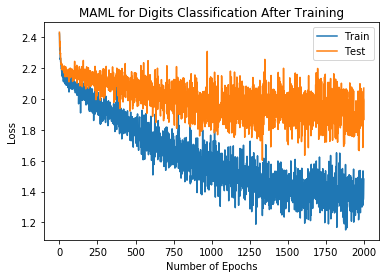

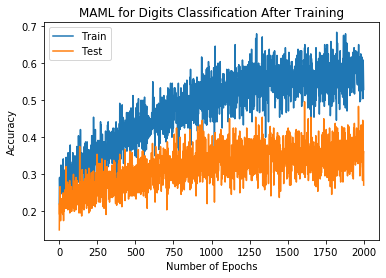

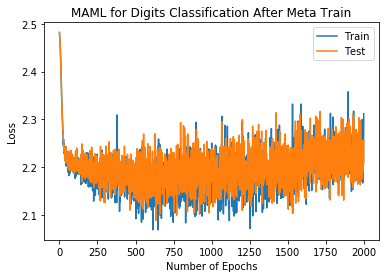

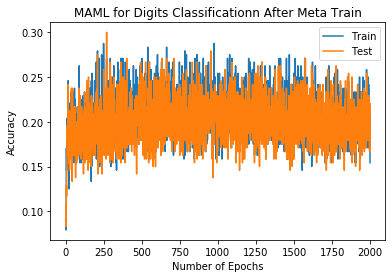

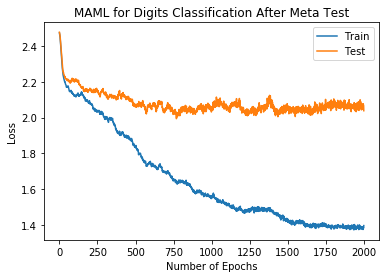

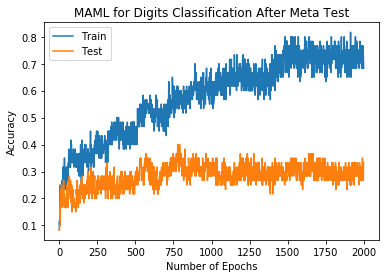

In [50]:
#plt.figure(figsize=(12,6))
plt.plot(afterTraining_train_loss, label='Train')
plt.plot(afterTraining_test_loss, label='Test')
plt.title('MAML for Digits Classification After Training') 
plt.xlabel('Number of Epochs') 
plt.ylabel('Loss')
plt.legend()
plt.show()

#plt.figure(figsize=(12,6))
plt.plot(afterTraining_train_acc, label='Train')
plt.plot(afterTraining_test_acc, label='Test')
plt.title('MAML for Digits Classification After Training') 
plt.xlabel('Number of Epochs') 
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#------------#
#plt.figure(figsize=(12,6))
plt.plot(afterMetaTrain_train_loss, label='Train')
plt.plot(afterMetaTrain_test_loss, label='Test')
plt.title('MAML for Digits Classification After Meta Train') 
plt.xlabel('Number of Epochs') 
plt.ylabel('Loss')
plt.legend()

plt.show()

#plt.figure(figsize=(12,6))
plt.plot(afterMetaTrain_train_acc, label='Train')
plt.plot(afterMetaTrain_test_acc, label='Test')
plt.title('MAML for Digits Classificationn After Meta Train') 
plt.xlabel('Number of Epochs') 
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#------------#
#plt.figure(figsize=(12,6))
plt.plot(afterMetaTest_train_loss, label='Train')
plt.plot(afterMetaTest_test_loss, label='Test')
plt.title('MAML for Digits Classification After Meta Test') 
plt.xlabel('Number of Epochs') 
plt.ylabel('Loss')
plt.legend()

plt.show()

#plt.figure(figsize=(12,6))
plt.plot(afterMetaTest_train_acc, label='Train')
plt.plot(afterMetaTest_test_acc, label='Test')
plt.title('MAML for Digits Classification After Meta Test') 
plt.xlabel('Number of Epochs') 
plt.ylabel('Accuracy')
plt.legend()

plt.show()

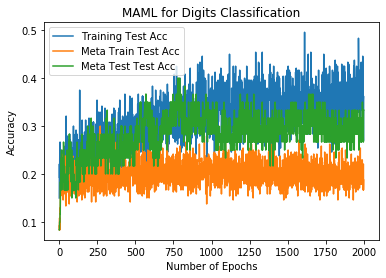

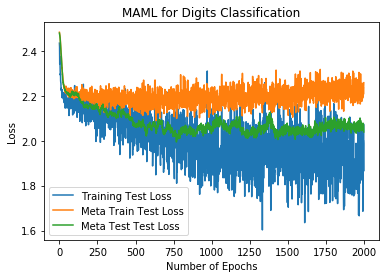

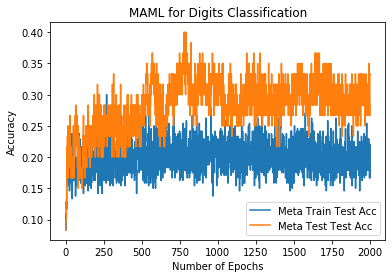

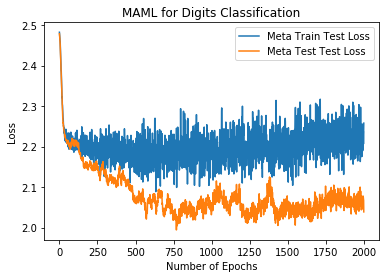

In [48]:
#plt.figure(figsize=(12,6))
plt.plot(afterTraining_test_acc, label='Training Test Acc')
plt.plot(afterMetaTrain_test_acc, label='Meta Train Test Acc')
plt.plot(afterMetaTest_test_acc, label='Meta Test Test Acc')
plt.title('MAML for Digits Classification') 
plt.xlabel('Number of Epochs') 
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#plt.figure(figsize=(12,6))
plt.plot(afterTraining_test_loss, label='Training Test Loss')
plt.plot(afterMetaTrain_test_loss, label='Meta Train Test Loss')
plt.plot(afterMetaTest_test_loss, label='Meta Test Test Loss')
plt.title('MAML for Digits Classification') 
plt.xlabel('Number of Epochs') 
plt.ylabel('Loss')
plt.legend()

plt.show()

#plt.figure(figsize=(12,6))
plt.plot(afterMetaTrain_test_acc, label='Meta Train Test Acc')
plt.plot(afterMetaTest_test_acc, label='Meta Test Test Acc')
plt.title('MAML for Digits Classification') 
plt.xlabel('Number of Epochs') 
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#plt.figure(figsize=(12,6))
plt.plot(afterMetaTrain_test_loss, label='Meta Train Test Loss')
plt.plot(afterMetaTest_test_loss, label='Meta Test Test Loss')
plt.title('MAML for Digits Classification') 
plt.xlabel('Number of Epochs') 
plt.ylabel('Loss')
plt.legend()

plt.show()

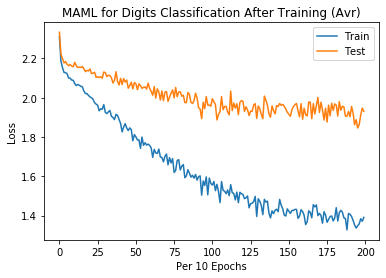

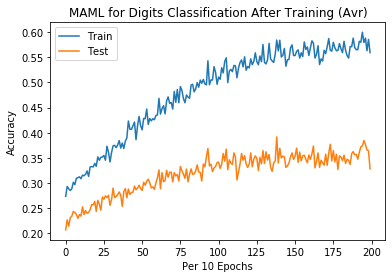

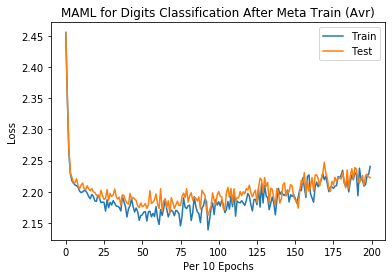

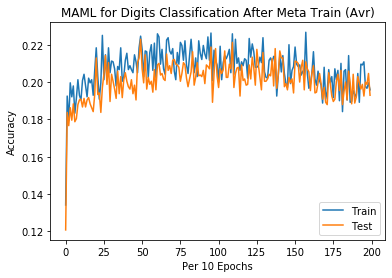

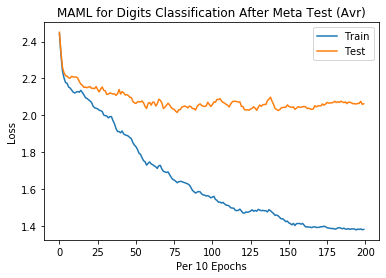

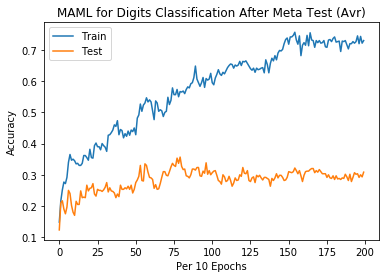

In [55]:
n = 10
avr_afterTraining_train_loss = np.mean(np.array(afterTraining_train_loss).reshape(-1, n), axis=1)
avr_afterTraining_test_loss = np.mean(np.array(afterTraining_test_loss).reshape(-1, n), axis=1)

avr_afterTraining_train_acc = np.mean(np.array(afterTraining_train_acc).reshape(-1, n), axis=1)
avr_afterTraining_test_acc = np.mean(np.array(afterTraining_test_acc).reshape(-1, n), axis=1)

#plt.figure(figsize=(12,6))
plt.plot(avr_afterTraining_train_loss, label='Train')
plt.plot(avr_afterTraining_test_loss, label='Test')
plt.title('MAML for Digits Classification After Training (Avr)') 
plt.xlabel('Per {} Epochs'.format(n)) 
plt.ylabel('Loss')
plt.legend()
plt.show()

#plt.figure(figsize=(12,6))
plt.plot(avr_afterTraining_train_acc, label='Train')
plt.plot(avr_afterTraining_test_acc, label='Test')
plt.title('MAML for Digits Classification After Training (Avr)') 
plt.xlabel('Per {} Epochs'.format(n)) 
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#------------#

avr_afterMetaTrain_train_loss = np.mean(np.array(afterMetaTrain_train_loss).reshape(-1, n), axis=1)
avr_afterMetaTrain_test_loss = np.mean(np.array(afterMetaTrain_test_loss).reshape(-1, n), axis=1)

avr_afterMetaTrain_train_acc = np.mean(np.array(afterMetaTrain_train_acc).reshape(-1, n), axis=1)
avr_afterMetaTrain_test_acc = np.mean(np.array(afterMetaTrain_test_acc).reshape(-1, n), axis=1)

#plt.figure(figsize=(12,6))
plt.plot(avr_afterMetaTrain_train_loss, label='Train')
plt.plot(avr_afterMetaTrain_test_loss, label='Test')
plt.title('MAML for Digits Classification After Meta Train (Avr)') 
plt.xlabel('Per {} Epochs'.format(n)) 
plt.ylabel('Loss')
plt.legend()

plt.show()

#plt.figure(figsize=(12,6))
plt.plot(avr_afterMetaTrain_train_acc, label='Train')
plt.plot(avr_afterMetaTrain_test_acc, label='Test')
plt.title('MAML for Digits Classification After Meta Train (Avr)') 
plt.xlabel('Per {} Epochs'.format(n)) 
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#------------#

avr_afterMetaTest_train_loss = np.mean(np.array(afterMetaTest_train_loss).reshape(-1, n), axis=1)
avr_afterMetaTest_test_loss = np.mean(np.array(afterMetaTest_test_loss).reshape(-1, n), axis=1)

avr_afterMetaTest_train_acc = np.mean(np.array(afterMetaTest_train_acc).reshape(-1, n), axis=1)
avr_afterMetaTest_test_acc = np.mean(np.array(afterMetaTest_test_acc).reshape(-1, n), axis=1)

#plt.figure(figsize=(12,6))
plt.plot(avr_afterMetaTest_train_loss, label='Train')
plt.plot(avr_afterMetaTest_test_loss, label='Test')
plt.title('MAML for Digits Classification After Meta Test (Avr)') 
plt.xlabel('Per {} Epochs'.format(n)) 
plt.ylabel('Loss')
plt.legend()

plt.show()

#plt.figure(figsize=(12,6))
plt.plot(avr_afterMetaTest_train_acc, label='Train')
plt.plot(avr_afterMetaTest_test_acc, label='Test')
plt.title('MAML for Digits Classification After Meta Test (Avr)') 
plt.xlabel('Per {} Epochs'.format(n)) 
plt.ylabel('Accuracy')
plt.legend()

plt.show()

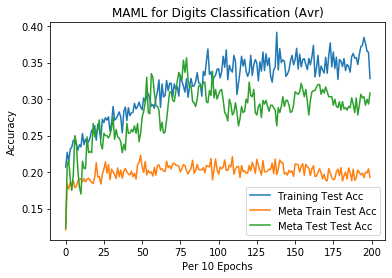

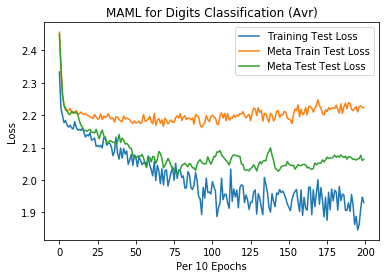

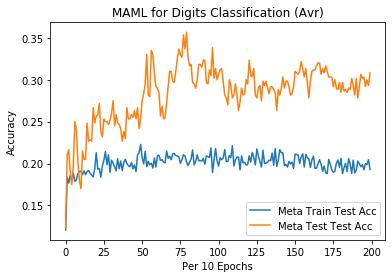

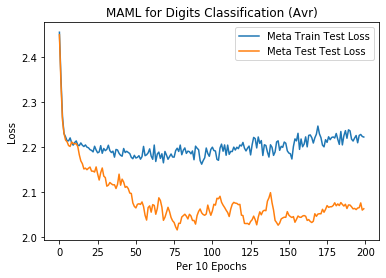

In [56]:
#plt.figure(figsize=(12,6))
plt.plot(avr_afterTraining_test_acc, label='Training Test Acc')
plt.plot(avr_afterMetaTrain_test_acc, label='Meta Train Test Acc')
plt.plot(avr_afterMetaTest_test_acc, label='Meta Test Test Acc')
plt.title('MAML for Digits Classification (Avr)') 
plt.xlabel('Per {} Epochs'.format(n)) 
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#plt.figure(figsize=(12,6))
plt.plot(avr_afterTraining_test_loss, label='Training Test Loss')
plt.plot(avr_afterMetaTrain_test_loss, label='Meta Train Test Loss')
plt.plot(avr_afterMetaTest_test_loss, label='Meta Test Test Loss')
plt.title('MAML for Digits Classification (Avr)') 
plt.xlabel('Per {} Epochs'.format(n)) 
plt.ylabel('Loss')
plt.legend()

plt.show()

#plt.figure(figsize=(12,6))
plt.plot(avr_afterMetaTrain_test_acc, label='Meta Train Test Acc')
plt.plot(avr_afterMetaTest_test_acc, label='Meta Test Test Acc')
plt.title('MAML for Digits Classification (Avr)') 
plt.xlabel('Per {} Epochs'.format(n)) 
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#plt.figure(figsize=(12,6))
plt.plot(avr_afterMetaTrain_test_loss, label='Meta Train Test Loss')
plt.plot(avr_afterMetaTest_test_loss, label='Meta Test Test Loss')
plt.title('MAML for Digits Classification (Avr)') 
plt.xlabel('Per {} Epochs'.format(n)) 
plt.ylabel('Loss')
plt.legend()

plt.show()

In [141]:
shots = 5
train, test = test_dataset.get_mini_dataset_paper(
    1, 50, shots, 10, split=True
)

In [144]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0000001)

In [146]:
mamlInt_maml_model,mamlInt_train_loss, mamlInt_train_acc, mamlInt_test_loss, mamlInt_test_acc = reptile_maml.reptile_test(train, test, epochs = 20, transfer_weights="True")

epoch: 0
60/60 [==============================] - 0s 2ms/step - loss: 2.1587 - categorical_accuracy: 0.2667
epoch: 1
60/60 [==============================] - 0s 2ms/step - loss: 2.1497 - categorical_accuracy: 0.2500
epoch: 2
60/60 [==============================] - 0s 2ms/step - loss: 2.1417 - categorical_accuracy: 0.2500
epoch: 3
60/60 [==============================] - 0s 2ms/step - loss: 2.1347 - categorical_accuracy: 0.2500
epoch: 4
60/60 [==============================] - 0s 2ms/step - loss: 2.1286 - categorical_accuracy: 0.2167
epoch: 5
60/60 [==============================] - 0s 2ms/step - loss: 2.1232 - categorical_accuracy: 0.2333
epoch: 6
60/60 [==============================] - 0s 2ms/step - loss: 2.1185 - categorical_accuracy: 0.2500
epoch: 7
60/60 [==============================] - 0s 2ms/step - loss: 2.1144 - categorical_accuracy: 0.2500
epoch: 8
60/60 [==============================] - 0s 2ms/step - loss: 2.1109 - categorical_accuracy: 0.2333
epoch: 9
60/60 [============

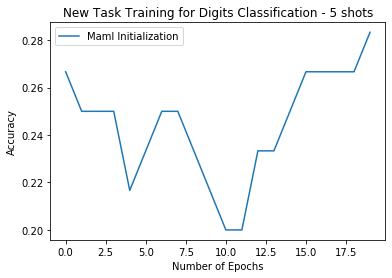

In [147]:
#plt.figure(figsize=(12,6))
plt.plot(mamlInt_test_acc, label='Maml Initialization')
plt.title('New Task Training for Digits Classification - {} shots'.format(shots)) 
plt.xlabel('Number of Epochs') 
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [90]:
mamlInt_maml_model,mamlInt_train_loss, mamlInt_train_acc, mamlInt_test_loss, mamlInt_test_acc = reptile_maml.reptile_test(train, test, epochs = 0, transfer_weights="True")
mamlInt_maml_model.save("C:\\Users\\ece_a\\Desktop\\Github\\studentproject\\Speech Recognition\\outputs\\Baseline Implementation\\Digits Classification")

INFO:tensorflow:Assets written to: C:\Users\ece_a\Desktop\Github\studentproject\Speech Recognition\outputs\Baseline Implementation\Digits Classification\assets


In [91]:
checkpoint_path = "C:\\Users\\ece_a\\Desktop\\Github\\studentproject\\Speech Recognition\\outputs\\Baseline Implementation\\Digits Classification\\cp-{epoch:04d}.ckpt"
mamlInt_maml_model,mamlInt_train_loss, mamlInt_train_acc, mamlInt_test_loss, mamlInt_test_acc = reptile_maml.reptile_test(train, test, epochs = 0, transfer_weights="True")
mamlInt_maml_model.save_weights(checkpoint_path.format(epoch=0))

## References:
- https://www.kdnuggets.com/2019/12/google-open-sources-mobilenetv3-improve-mobile-computer-vision-models.html